# Multiclass Semantic Segmentation using CamVid dataset

In [1]:
#Importing libraries
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

import os
import shutil
from tqdm import tqdm

import random
from sklearn.utils import shuffle
import tensorflow_addons as tfa
#import skimage

## Check system environment


In [2]:
print("Tensorflow version: ",tf.__version__)

print("Is GPU available: {}".format(tf.test.is_gpu_available()))

Tensorflow version:  2.1.0


W0317 20:55:21.184571 24896 deprecation.py:323] From <ipython-input-2-d03a236d2262>:3: is_gpu_available (from tensorflow.python.framework.test_util) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Is GPU available: True


## Data preparation - Import data, clean and creating structured directory


## Important variables to be set before running the notebook

In [3]:

# Set DEBUG level.  When debug flag is on, additional results and print statements are shown in the results
DEBUG = True

# Do you want to train model, or load a previously saved model?
flag_train_model = True # Load saved model, or train new

flag_use_weighted_loss_fcn =False


### Image directory location and the input image size. 

In [4]:
img_dir = "..\data\CamSeq01"

#Required image dimensions
IMG_HEIGHT = 256
IMG_WIDTH = 256
INPUT_CHANNELS =3


## Reading frames and masks
. Mask file names end with "_L.png"

In [5]:
def separate_data_from_labels(img_dir):
    '''
    '''
#     regexp_path = str(os.path.join(img_dir,"*"))
#     list_ds = tf.data.Dataset.list_files(regexp_path)    
#     for f in list_ds.take(5):
#         print(f.numpy())

    #Get all the file names list from the directory
    all_file_list = [f for f in os.listdir(img_dir) if f.endswith(".png")]
    print("Total PNG files in the folder: {}".format(len(all_file_list)))
    
    # Get actual images
    frame_files_list =[os.path.join(img_dir,f) for f in all_file_list if "_L" not in f]

    image_count = len(frame_files_list)
    # Get masks - Get the files with _L in their name
    mask_files_list =[os.path.join(img_dir,f) for f in all_file_list if "_L" in f]
    
    print("Trainable frames in the folder: {}".format(image_count))
    print("Mask images in the folder: {}".format(len(mask_files_list)))

#     data_list_ds = tf.data.Dataset.from_tensor_slices(img_files_list)
#     mask_list_ds = tf.data.Dataset.from_tensor_slices(mask_files_list)

    
    return frame_files_list, mask_files_list

# read_images(img_dir)
frame_files_list, mask_files_list = separate_data_from_labels(img_dir)


Total PNG files in the folder: 202
Trainable frames in the folder: 101
Mask images in the folder: 101


In [6]:
# Make the train validation folder

folders = ['train_frames\\frames', 'train_masks\\masks', 'val_frames\\frames', 'val_masks\\masks']

for folder in folders:
    try:
        os.makedirs(os.path.join(img_dir,folder))
    except Exception as ex:
        print(ex)
        

train_frames_folder = os.path.join(img_dir,'train_frames')
train_masks_folder = os.path.join(img_dir,'train_masks')


validation_frames_folder = os.path.join(img_dir,'val_frames')
validation_masks_folder = os.path.join(img_dir,'val_masks')
    
        
    

[WinError 183] Cannot create a file when that file already exists: '..\\data\\CamSeq01\\train_frames\\frames'
[WinError 183] Cannot create a file when that file already exists: '..\\data\\CamSeq01\\train_masks\\masks'
[WinError 183] Cannot create a file when that file already exists: '..\\data\\CamSeq01\\val_frames\\frames'
[WinError 183] Cannot create a file when that file already exists: '..\\data\\CamSeq01\\val_masks\\masks'


### Separate out the files into folders

In [7]:
if len(os.listdir(os.path.join(train_frames_folder,'frames')))==0:

    validation_fraction = 0.2
    total_samples = len(frame_files_list)

    num_validation_samples = int(np.ceil(validation_fraction*total_samples))
    num_training_samples = total_samples - num_validation_samples
    print("Total samples: {}".format(total_samples))

    # Get random indices for separating the validation samples

    idx_range = np.arange(total_samples)
    shuffled_idx = shuffle(idx_range, random_state=33)
    print(shuffled_idx)
    
    # print(shuffled_idx)
    idx_validation = shuffled_idx[:num_validation_samples]
    idx_train = shuffled_idx[num_validation_samples:]

    # Move the validation and trainng samples to the correct folders

    # Move training frames
    [shutil.copy(frame_files_list[i], os.path.join(train_frames_folder,'frames',os.path.split(frame_files_list[i])[-1])) for i in idx_train]

    # Move training masks
    [shutil.copy(mask_files_list[i], os.path.join(train_masks_folder,'masks',os.path.split(mask_files_list[i])[-1])) for i in idx_train]


    # Move validation frames
    [shutil.copy(frame_files_list[i], os.path.join(validation_frames_folder,'frames',os.path.split(frame_files_list[i])[-1])) for i in idx_validation]

    # Move validation masks
    [shutil.copy(mask_files_list[i], os.path.join(validation_masks_folder,'masks',os.path.split(mask_files_list[i])[-1])) for i in idx_validation]

    print("File copying complete")
    
else:
    print("Training / validation folders already exists, not copying files")
    num_training_samples = len(os.listdir(os.path.join(train_frames_folder,'frames')))
    num_validation_samples = len(os.listdir(os.path.join(validation_frames_folder,'frames')))

idx_range = np.arange(100)
shuffled_idx = shuffle(idx_range, random_state=33)
# print(shuffled_idx)

print("Num training samples: {}".format(num_training_samples))
print("Num validation samples: {}".format(num_validation_samples))

asd = os.listdir(os.path.join(train_frames_folder,'frames'))
asd = os.path.join(train_frames_folder,'frames',asd[0])
print(asd)
print("Shape of image: {}".format(plt.imread(asd).shape))
        

Training / validation folders already exists, not copying files
Num training samples: 80
Num validation samples: 21
..\data\CamSeq01\train_frames\frames\0016E5_07959.png
Shape of image: (720, 960, 3)


### Extract the labels for each class
The masks have RGB triplets for each class. I need to modify this into class ids


In [8]:
labels_fname = os.path.join(img_dir,'label_colors.txt')

dict_idx_class = {}
dict_idx_rgb =   {}

with open(labels_fname) as fp:
    for cnt,line in enumerate(fp):
        
        # Separate componenets of each line. The name is separate from the rgb triplet by a tab
        x =line.split("\t")
        rgb_value = x[0]
        
        # Need the RGB in int not as a string
        rgb_value = tuple(int(i) for i in rgb_value.split(" "))

        # Extract the class names
        class_name = x[-1].rstrip()
        
#         print("Line number: {}, class: {}, rgb triplet: {}".format(cnt,class_name,rgb_value))
        
        #Create a dictionary of idx-name pairs
        dict_idx_class[cnt]=class_name
        dict_idx_rgb[cnt]=rgb_value

n_classes = len(dict_idx_class)
print("Number of classes in the image: {}".format(n_classes))


Number of classes in the image: 32


In [9]:
print("Idx to class dictionary:")
dict_idx_class


Idx to class dictionary:


{0: 'Animal',
 1: 'Archway',
 2: 'Bicyclist',
 3: 'Bridge',
 4: 'Building',
 5: 'Car',
 6: 'CartLuggagePram',
 7: 'Child',
 8: 'Column_Pole',
 9: 'Fence',
 10: 'LaneMkgsDriv',
 11: 'LaneMkgsNonDriv',
 12: 'Misc_Text',
 13: 'MotorcycleScooter',
 14: 'OtherMoving',
 15: 'ParkingBlock',
 16: 'Pedestrian',
 17: 'Road',
 18: 'RoadShoulder',
 19: 'Sidewalk',
 20: 'SignSymbol',
 21: 'Sky',
 22: 'SUVPickupTruck',
 23: 'TrafficCone',
 24: 'TrafficLight',
 25: 'Train',
 26: 'Tree',
 27: 'Truck_Bus',
 28: 'Tunnel',
 29: 'VegetationMisc',
 30: 'Void',
 31: 'Wall'}

In [10]:
print("Idx to rgb triplet dictionary:")
dict_idx_rgb


Idx to rgb triplet dictionary:


{0: (64, 128, 64),
 1: (192, 0, 128),
 2: (0, 128, 192),
 3: (0, 128, 64),
 4: (128, 0, 0),
 5: (64, 0, 128),
 6: (64, 0, 192),
 7: (192, 128, 64),
 8: (192, 192, 128),
 9: (64, 64, 128),
 10: (128, 0, 192),
 11: (192, 0, 64),
 12: (128, 128, 64),
 13: (192, 0, 192),
 14: (128, 64, 64),
 15: (64, 192, 128),
 16: (64, 64, 0),
 17: (128, 64, 128),
 18: (128, 128, 192),
 19: (0, 0, 192),
 20: (192, 128, 128),
 21: (128, 128, 128),
 22: (64, 128, 192),
 23: (0, 0, 64),
 24: (0, 64, 64),
 25: (192, 64, 128),
 26: (128, 128, 0),
 27: (192, 128, 192),
 28: (64, 0, 64),
 29: (192, 192, 0),
 30: (0, 0, 0),
 31: (64, 192, 0)}

### Create functions for converting onehot vectors into the colormap and colormap into onehot vectors 

In [11]:
def rgb_to_onehot(rgb_image,dict_idx_rgb):
    '''
    Take a rgb label image and return a onehot image as input with h x w x n_classes
    '''
    
    rgb_image =rgb_image.astype(np.int)
    # Create empty array of size m x n x n_classes
    onehot_image = np.zeros((rgb_image.shape[0],rgb_image.shape[1],n_classes),dtype=np.uint8)

    # assign True depending on the rgb triplet
    for idx in range(n_classes):
        onehot_image[:,:,idx] = np.all(rgb_image.reshape(-1,3) == dict_idx_rgb[idx],axis=1).reshape(rgb_image.shape[:2])
    
#     print(onehot_image[:,:,4])        
#     print(onehot_image.shape)    
    return onehot_image


def onehot_to_rgb(onehot_image,dict_idx_rgb):
    '''
    Take a onehot image as input with h x w x n_classes, and return a rgb image
    '''
    
    #Get 1 channel image
    onehot_single_channel = np.argmax(onehot_image,axis=-1) 
    
    rgb_image = np.zeros((onehot_image.shape[0],onehot_image.shape[1],3),dtype=np.uint8)

    for i in dict_idx_rgb.keys():
#         rgb_image[onehot_single_channel==i] == dict_idx_rgb[i]

        rgb_image[onehot_single_channel==i] = dict_idx_rgb[i]

#     print(np.max(np.argmax(onehot_image,axis=2)))
#     print(onehot_single_channel)

    return rgb_image 

def rgb_to_class_id(rgb_image,dict_idx_rgb, dict_idx_class):
    '''
    Take a rgb label image and return a class id image of shape  h x w
    '''
    rgb_image =rgb_image.astype(np.int)
    # Create empty array of size m x n x n_classes
    class_id_image = np.zeros((rgb_image.shape[0],rgb_image.shape[1]),dtype=np.uint8)

    # assign True depending on the rgb triplet
    for idx in range(n_classes):
        class_id_idx = np.all(rgb_image.reshape(-1,3) == dict_idx_rgb[idx],axis=1).reshape(rgb_image.shape[:2])
        class_id_image[class_id_idx] = idx
        
#     print(onehot_image[:,:,4])        
#     print(onehot_image.shape)    
    return class_id_image

# out = rgb_to_onehot(mask_array[0], dict_idx_rgb)    
# out = onehot_to_rgb(np.zeros((256,256,32)), dict_idx_rgb)    
# plt.imshow(out[:,:,4])


### Use the ImageDataGenerators for creating batches of data for training and validation

Note that, in this case, I can't use the keras iamge generator as is. The mask image is in rgb triplets.
This triplet data has to be converted into class idx/ onehot matrices before being sent to the training model.


In [12]:
frame_gen_args = dict(rescale=1/255.0)
mask_gen_args = dict()

train_frame_generator = keras.preprocessing.image.ImageDataGenerator(**frame_gen_args)
train_mask_generator = keras.preprocessing.image.ImageDataGenerator(**mask_gen_args)

validate_frame_generator = keras.preprocessing.image.ImageDataGenerator(**frame_gen_args)
validate_mask_generator = keras.preprocessing.image.ImageDataGenerator(**mask_gen_args)


### Create the custom image data generator

In [13]:
# max_tx=10
# max_ty=20
# batch_size=3

# tx = tf.random.uniform((batch_size,1),minval=-max_tx, maxval=max_tx)
# ty = tf.random.uniform((batch_size,1),minval=-max_ty, maxval=max_ty)

# disp_xy = tf.random.uniform((batch_size,2),minval=-max_tx, maxval=max_tx)

# # out =np.hstack((tx,ty))
# # out = np.array([tx,ty])
# print(disp_xy.numpy())
# # print(tx.numpy())
# # print(ty)

In [14]:
# def gentest():
    
#     init_val = np.random.randint(1,100)
    
#     print("Init val: {}".format(init_val))
#     final_val=0
#     while (1):
#         final_val = final_val+1
#         print(final_val)
    
#     yield final_val

# type(gentest())    
# for i in range(1):
#     next(gentest())
    

In [15]:
def TrainingDataGenerator(seed=1, batch_size=5):
    
    # Use the ImageGenerator syntax to get data from directory
    print("In TrainingDataGenerator ")
    flag_first_time = True
    
    if(flag_first_time):
        print("Initializing  TrainingDataGenerator ")
        seed =np.random.randint(0,1e3)

        train_frames_data = train_frame_generator.flow_from_directory(train_frames_folder,
                                                              seed=seed,
                                                              batch_size=batch_size,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH))


        train_masks_data = train_mask_generator.flow_from_directory(train_masks_folder,
                                                              seed=seed,
                                                              batch_size=batch_size,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH))

        flag_first_time = False

    current_batch_frames = train_frames_data.next()
    current_batch_masks  = train_masks_data.next()

    while True:
        # Extract a batch of data
        current_batch_frames = train_frames_data.next()
        current_batch_masks  = train_masks_data.next()

#         print("current_batch_frames.shape:", current_batch_frames.shape)
        # Create the out array for 1 hot encoding
        onehot_batch_masks = np.zeros(current_batch_masks[0].shape[0:3]+(n_classes,),dtype=np.float32)

        out_im_array = current_batch_frames[0]
    #         print("out_im_array.shape: ", out_im_array.shape)
    #         print("current_batch_frames[1]: ", current_batch_frames[1])
    #         mask_array = current_batch_masks[0]

        # Create the onehot mask
        for i in range(batch_size):
            onehot_batch_masks[i] = rgb_to_onehot(current_batch_masks[0][i],dict_idx_rgb)

        # Data Augmentation        
        for i in range(batch_size):

            # Data augmentation left right flip
            if np.random.random() > 0.5:
                out_im_array[i] = np.fliplr(out_im_array[i])
                onehot_batch_masks[i] = np.fliplr(onehot_batch_masks[i])

            # Data augmentation rotate
            if tf.random.uniform(()) > 0.5:

                max_rot_angle_deg = 10 # +- x
                rotate_deg = tf.random.uniform(()) * max_rot_angle_deg - max_rot_angle_deg/2
                rotate_rads = rotate_deg*(np.pi/180)
#                 print(rotate_deg)
                out_im_array[i] = tfa.image.rotate(out_im_array[i], rotate_rads)
    #             out_im_array = skimage.transform.rotate(out_im_array,rotate_deg)
                onehot_batch_masks[i] = tfa.image.rotate(onehot_batch_masks[i], rotate_rads)

            # Data augmentation shift
            if tf.random.uniform(()) > 0.5:
                max_tx= 10 #px
                disp_xy = tf.random.uniform((1,2),minval=-max_tx, maxval=max_tx)
                out_im_array[i] =tfa.image.translate(out_im_array[i],disp_xy.numpy())
                onehot_batch_masks[i] = tfa.image.translate(onehot_batch_masks[i],disp_xy.numpy())
                
        yield (out_im_array, onehot_batch_masks)

####################################################
#####################################################
###########################################################
#     #From this batch, modify the mask so that the n x height x width x 3 data is transformed into n x height x width x n_classes
#     # Create the generator
#     while 1:

#         print("In TrainingDataGenerator-python gnenerator section ")
#         # Extract a batch of data
#         current_batch_frames = train_frames_data.next()
#         current_batch_masks  = train_masks_data.next()

#     #     print("current_batch_frames.shape:")
#         # Create the out array for 1 hot encoding
#         onehot_batch_masks = np.zeros(current_batch_masks[0].shape[0:3]+(n_classes,),dtype=np.float32)

#         out_im_array = current_batch_frames[0]
# #         print("out_im_array.shape: ", out_im_array.shape)
# #         print("current_batch_frames[1]: ", current_batch_frames[1])
# #         mask_array = current_batch_masks[0]
        
#         # Create the onehot mask
#         for i in range(batch_size):
#             onehot_batch_masks[i] = rgb_to_onehot(current_batch_masks[0][i],dict_idx_rgb)

#         # Data Augmentation        
#         for i in range(batch_size):
            
# #             # Data augmentation left right flip
# #             if np.random.random() > 0.5:
# #                 out_im_array[i] = np.fliplr(out_im_array[i])
# #                 onehot_batch_masks[i] = np.fliplr(onehot_batch_masks[i])

#             # Data augmentation left right flip
#             if tf.random.uniform(()) > 0.5:
#                 out_im_array[i] = tf.image.flip_left_right(out_im_array[i])
#                 onehot_batch_masks[i] = tf.image.flip_left_right(onehot_batch_masks[i])

# #             # Data augmentation rotate
# #             if tf.random.uniform(()) > 0.5:

# #                 max_rot_angle_deg = 10 # +- x
# #                 rotate_deg = tf.random.uniform(()) * max_rot_angle_deg - max_rot_angle_deg/2
# #                 rotate_rads = rotate_deg*(np.pi/180)
# # #                 print(rotate_deg)
# #                 out_im_array[i] = tfa.image.rotate(out_im_array[i], rotate_rads)
# #     #             out_im_array = skimage.transform.rotate(out_im_array,rotate_deg)
# #                 onehot_batch_masks[i] = tfa.image.rotate(onehot_batch_masks[i], rotate_rads)

# #             # Data augmentation shift
# #             if tf.random.uniform(()) > 0.5:
# #                 max_tx= 10 #px
# #                 disp_xy = tf.random.uniform((1,2),minval=-max_tx, maxval=max_tx)
# #                 out_im_array[i] =tfa.image.translate(out_im_array[i],disp_xy.numpy())
# #                 onehot_batch_masks[i] = tfa.image.translate(onehot_batch_masks[i],disp_xy.numpy())

        
        
# #         # Data augmentation shift
# # #         if tf.random.uniform(()) > 0.5:
# #         max_tx= 40 #px
# # #                 max_ty= 10 #px                
# #         tx = tf.random.uniform((batch_size,),minval=-max_tx, maxval=max_tx)

# #         disp_xy = tf.random.uniform((batch_size,2),minval=-max_tx, maxval=max_tx)
# #         out_im_array =tfa.image.translate(out_im_array,disp_xy.numpy())
# #         onehot_batch_masks = tfa.image.translate(onehot_batch_masks,disp_xy.numpy())
        
#         # When augmenting, the shifts cause 0 values in RGB, which get assigned to "Animal class".
        
# #         for i in range(batch_size):
# #             # Get all onehot first channel
# #             animal_idx =onehot_batch_masks[i,:,:,0]
# #             asd =[]
    
#         yield out_im_array, onehot_batch_masks
        


def ValidationDataGenerator(seed=1, batch_size=5):
    
    # Use the ImageGenerator syntax to get data from directory
    print("In ValidationDataGenerator ")
    flag_first_time_validation_gen =True
        
    if(flag_first_time_validation_gen):            
        print("Initializing  ValidationDataGenerator ")
        seed =np.random.randint(0,1e3)

        valid_frames_data = validate_frame_generator.flow_from_directory(validation_frames_folder,
                                                              seed=seed,
    #                                                           shuffle=False,
                                                              batch_size=batch_size,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH))


        valid_masks_data = validate_mask_generator.flow_from_directory(validation_masks_folder,
                                                              seed=seed,
    #                                                           shuffle=False,
                                                              batch_size=batch_size,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH))


        flag_first_time_validation_gen = False
        #From this batch, modify the mask so that the n x height x width x 3 data is transformed into n x height x width x n_classes
        # Create the generator
        # Extract a batch of data
        
#     current_batch_frames = valid_frames_data.next()
#     current_batch_masks  = valid_masks_data.next()
    while True:
#         # Extract a batch of data
        current_batch_frames = valid_frames_data.next()
        current_batch_masks  = valid_masks_data.next()

        # Create the out array for 1 hot encoding
        onehot_batch_masks = np.zeros(current_batch_masks[0].shape[0:3]+(n_classes,))

#         print("onehot_batch_masks.shape: ", onehot_batch_masks.shape)
#         print("current_batch_frames[0].shape: ", current_batch_frames[0].shape)
#         print("current_batch_masks[0].shape: ", current_batch_masks[0].shape)

        for i in range(batch_size):
            onehot_batch_masks[i] = rgb_to_onehot(current_batch_masks[0][i],dict_idx_rgb)
        
#         print("onehot_batch_masks shape: ",onehot_batch_masks.shape)
        yield (current_batch_frames[0],onehot_batch_masks)
        


        
# Testing 

if DEBUG:
    
    print("Testing TrainingDataGenerator")
    m_batch = TrainingDataGenerator()
    test_batch = next(m_batch)
    im_array = test_batch[0]
    onehot_array = test_batch[1]

    print("im_array shape: {}, dtype: {}".format(im_array.shape, im_array.dtype))
    print("onehot_array shape:{}, dtype: {}".format(onehot_array.shape,onehot_array.dtype))

    print("Testing ValidationDataGenerator")

    m_batch = ValidationDataGenerator()


    test_batch = next(m_batch)
    im_array = test_batch[0]
    onehot_array = test_batch[1]

    print("im_array shape: ", im_array.shape)
    print("onehot_array shape: ", onehot_array.shape)



Testing TrainingDataGenerator
In TrainingDataGenerator 
Initializing  TrainingDataGenerator 
Found 80 images belonging to 1 classes.
Found 80 images belonging to 1 classes.
im_array shape: (5, 256, 256, 3), dtype: float32
onehot_array shape:(5, 256, 256, 32), dtype: float32
Testing ValidationDataGenerator
In ValidationDataGenerator 
Initializing  ValidationDataGenerator 
Found 21 images belonging to 1 classes.
Found 21 images belonging to 1 classes.
im_array shape:  (5, 256, 256, 3)
onehot_array shape:  (5, 256, 256, 32)


### Display some of the images  

<class 'generator'>
getting new  batch
In TrainingDataGenerator 
Initializing  TrainingDataGenerator 
Found 80 images belonging to 1 classes.
Found 80 images belonging to 1 classes.
getting new  batch
getting new  batch


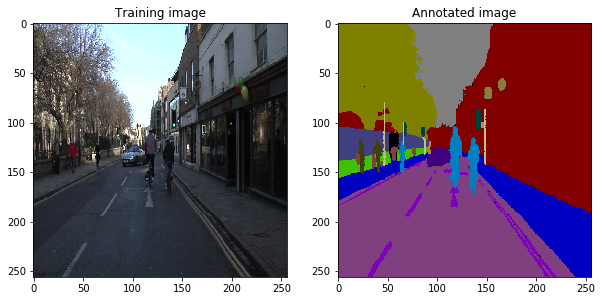

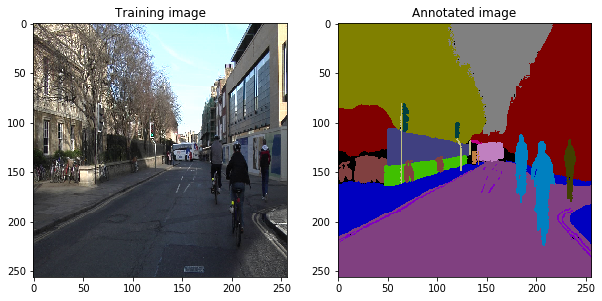

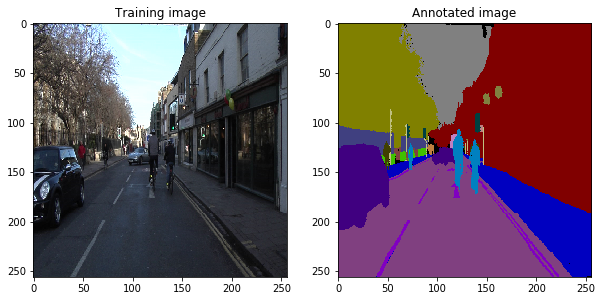

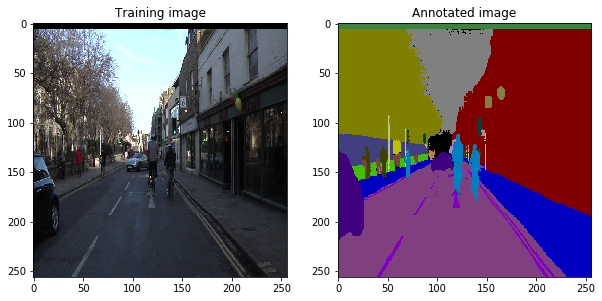

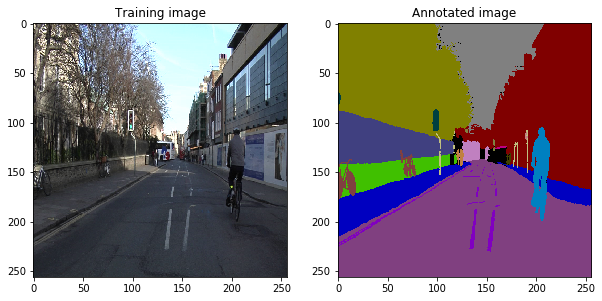

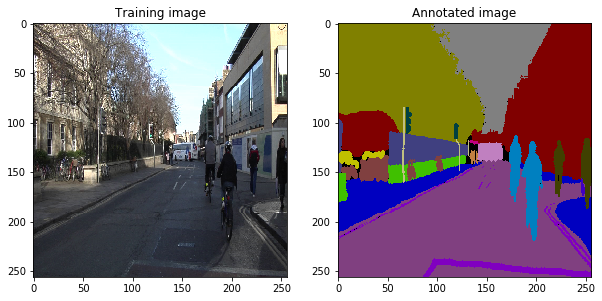

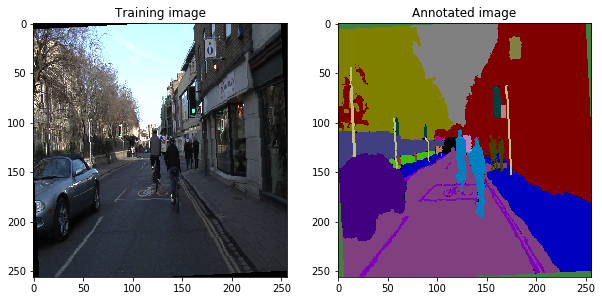

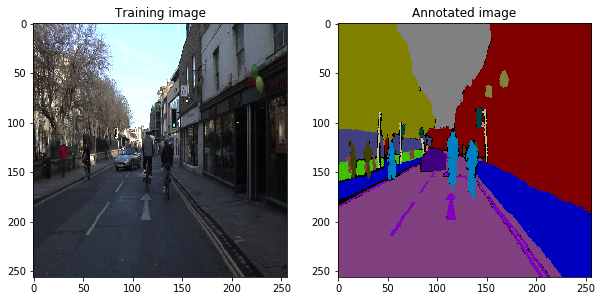

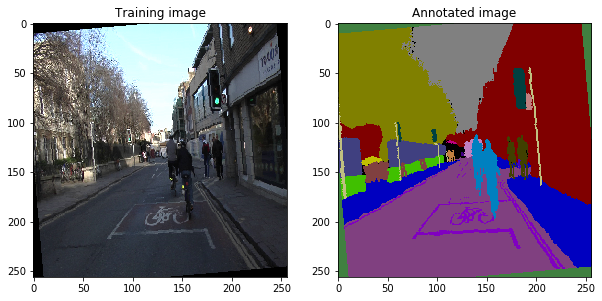

In [16]:
m_batch = TrainingDataGenerator(batch_size=3)
print(type(m_batch))
for j in range(3):
    print("getting new  batch")
    test_batch = next(m_batch)

    im_array = test_batch[0]
    onehot_array = test_batch[1]

    for i in range(im_array.shape[0]):
        plt.figure(figsize=(10,10))
        plt.subplot(1,2,1)
        plt.imshow(im_array[i])
        plt.title("Training image")
        plt.subplot(1,2,2)
        plt.imshow(onehot_to_rgb(onehot_array[i],dict_idx_rgb))
        plt.title("Annotated image")
    

<class 'generator'>
>>>>>>>>>> j=0 getting new  batch
In ValidationDataGenerator 
Initializing  ValidationDataGenerator 
Found 21 images belonging to 1 classes.
Found 21 images belonging to 1 classes.
im_array.shape:  (5, 256, 256, 3)
onehot_array.shape:  (5, 256, 256, 32)
>>>>>>>>>> j=1 getting new  batch
im_array.shape:  (5, 256, 256, 3)
onehot_array.shape:  (5, 256, 256, 32)
>>>>>>>>>> j=2 getting new  batch
im_array.shape:  (5, 256, 256, 3)
onehot_array.shape:  (5, 256, 256, 32)
>>>>>>>>>> j=3 getting new  batch
im_array.shape:  (5, 256, 256, 3)
onehot_array.shape:  (5, 256, 256, 32)


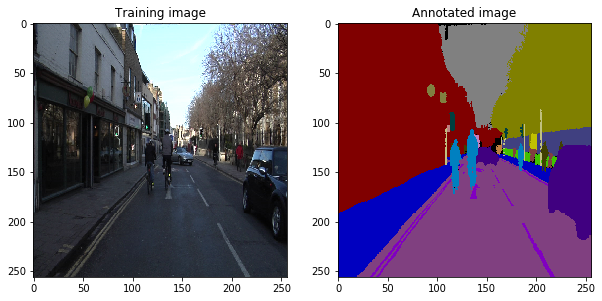

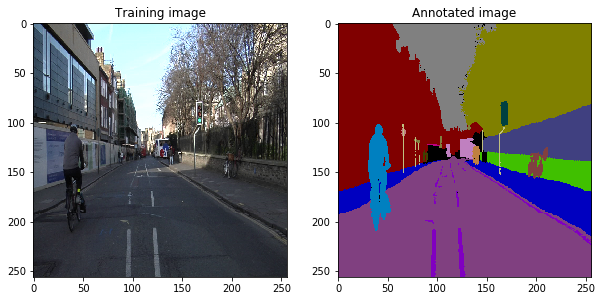

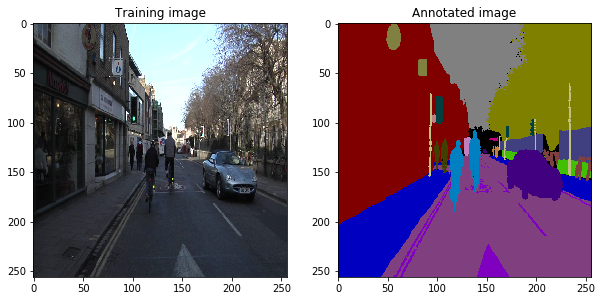

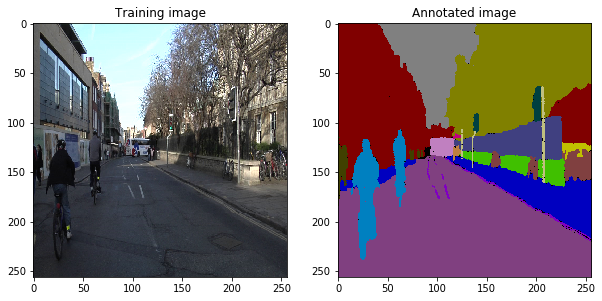

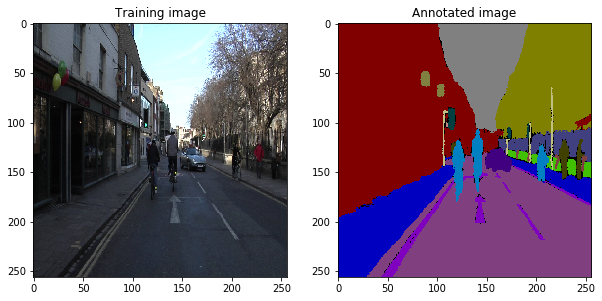

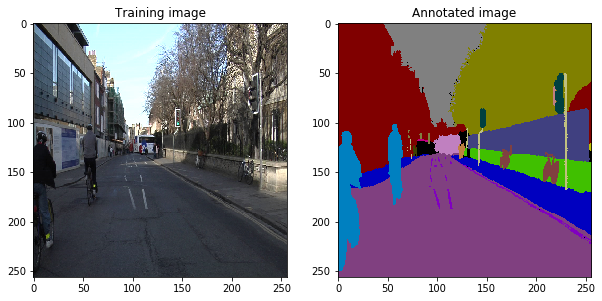

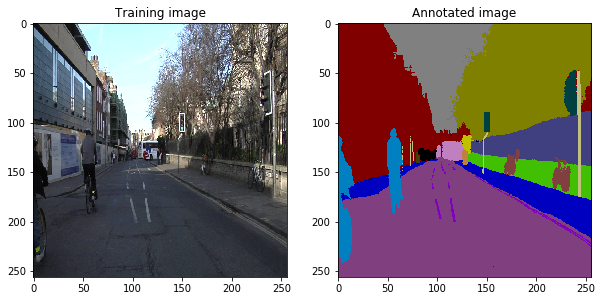

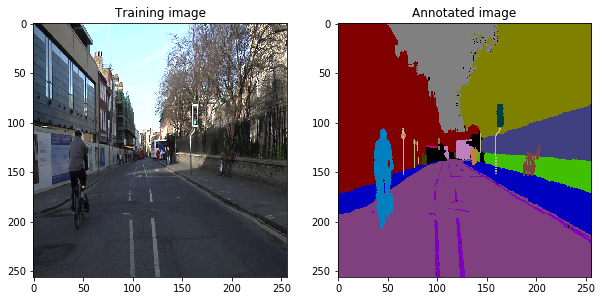

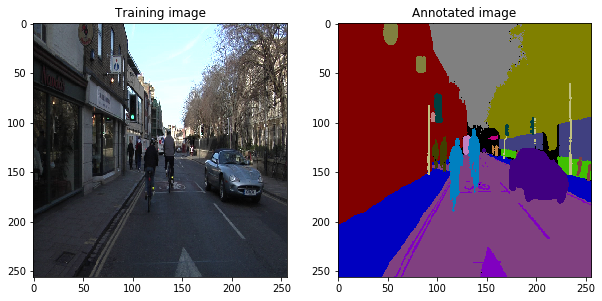

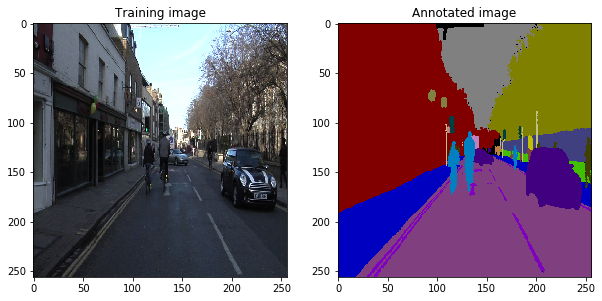

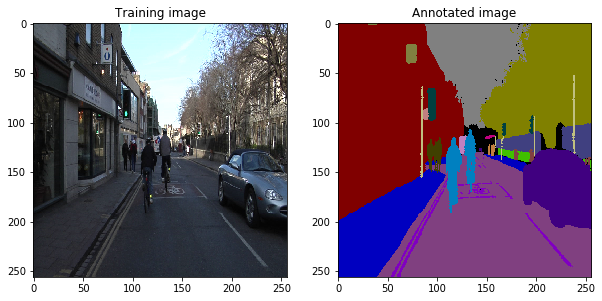

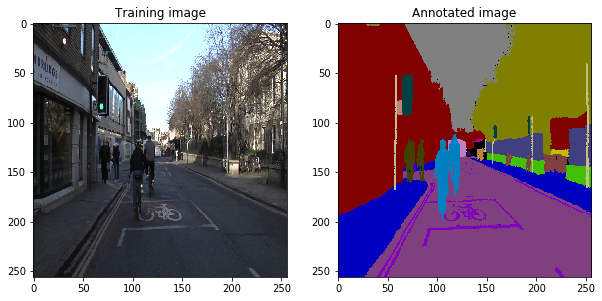

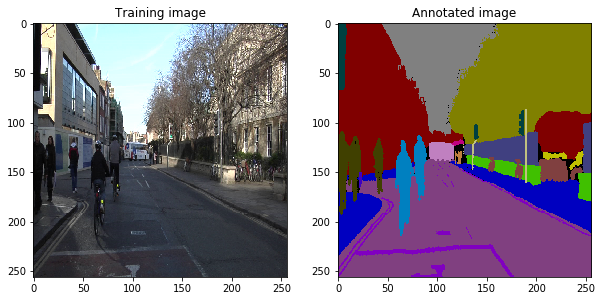

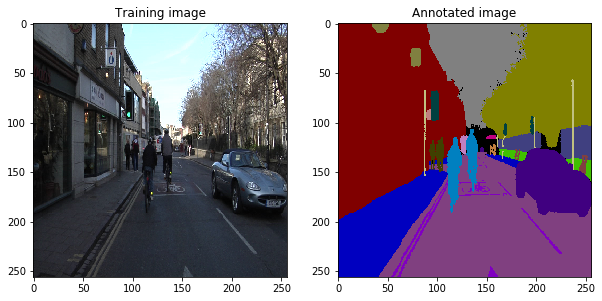

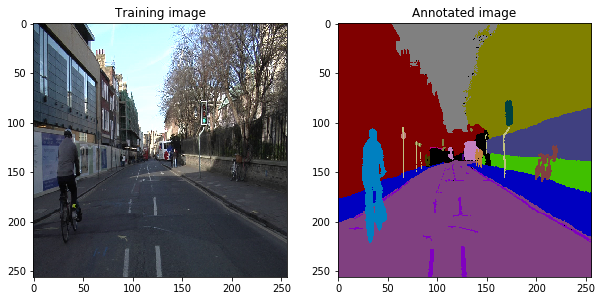

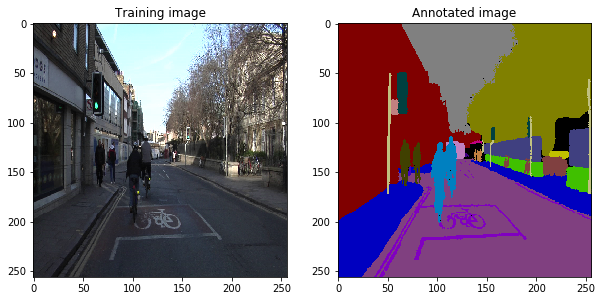

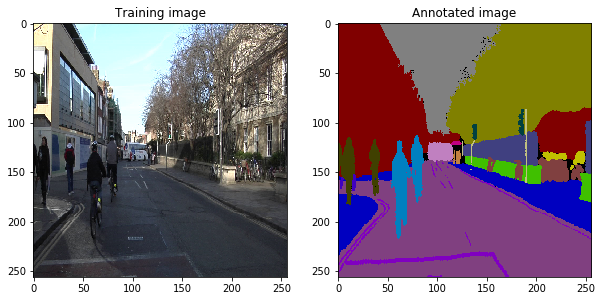

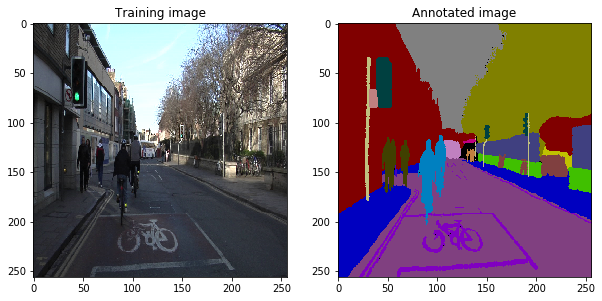

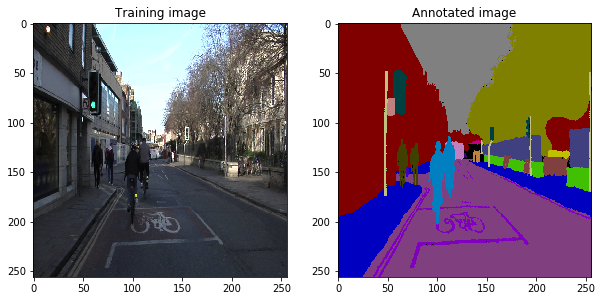

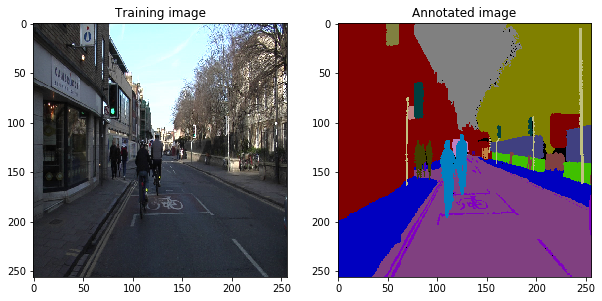

In [17]:
m_batch = ValidationDataGenerator(batch_size=5)
print(type(m_batch))
for j in range(4):
    print(">>>>>>>>>> j={} getting new  batch".format(j))
    test_batch = next(m_batch)

    im_array = test_batch[0]
    onehot_array = test_batch[1]
    
    print("im_array.shape: ", im_array.shape)
    print("onehot_array.shape: ", onehot_array.shape)

    for i in range(im_array.shape[0]):
        plt.figure(figsize=(10,10))
        plt.subplot(1,2,1)
        plt.imshow(im_array[i])
        plt.title("Training image")
        plt.subplot(1,2,2)
        plt.imshow(onehot_to_rgb(onehot_array[i],dict_idx_rgb))
        plt.title("Annotated image")


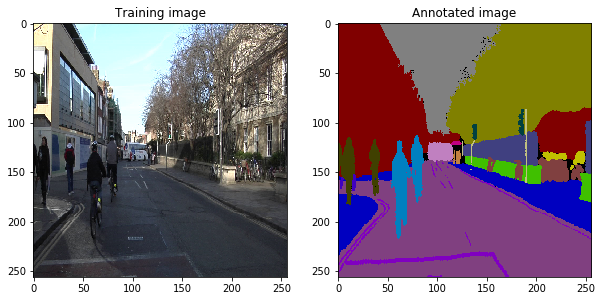

In [18]:
i=1
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(im_array[i])
plt.title("Training image")
plt.subplot(1,2,2)
m_image = onehot_to_rgb(onehot_array[i],dict_idx_rgb)
plt.imshow(m_image)
plt.title("Annotated image")

asd = rgb_to_class_id(m_image,dict_idx_rgb, dict_idx_class)

# print(im_array[i])
# print(onehot_array[i])

# print(m_image)

# print(asd)

### Is there class imbalance?

Extract the pixels classifications


In [19]:
base_dir = os.path.join(train_masks_folder,'masks')

# fname = os.listdir(base_dir)[4]

hist_array=[]
for idx,fname in enumerate(tqdm(os.listdir(base_dir))):
    fpath = os.path.join(base_dir,fname)
#     print(fpath)
    # Using tf.io.read. matplotlib.pyplot.imread reads the image as floatss 0 - 1 , while I need the data as 0-255.
    # This is cleaner.

    img = tf.io.read_file(fpath)
    img = tf.io.decode_png(img)
    # print(img)
#     plt.imshow(img)
    
    class_image = rgb_to_class_id(img.numpy(),dict_idx_rgb, dict_idx_class)
    hist_array.append(np.reshape(class_image,(-1,)))

# Compbine all the values into a single vector
all_idx =np.array(hist_array).reshape(-1)






100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:38<00:00,  2.09it/s]


### Display the histogram of class label distribution 

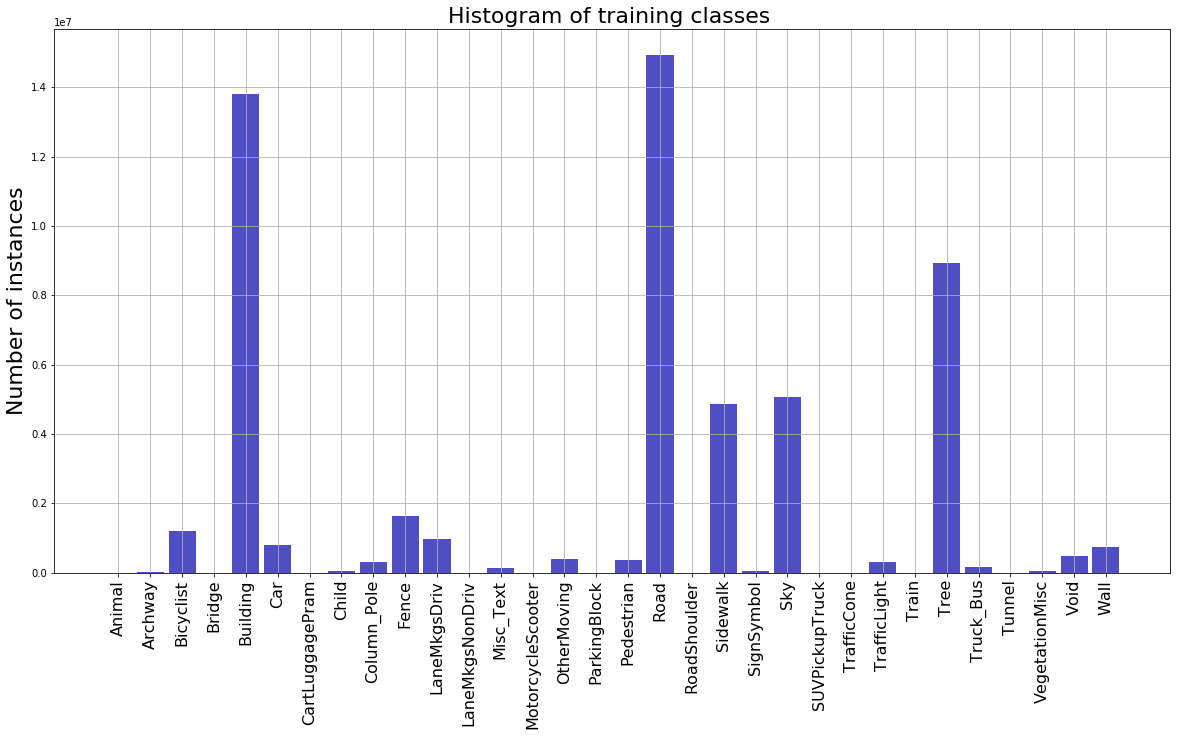

In [20]:
def plot_class_histogram(class_vec,dict_idx_class, n_classes):
    
    plt.figure(figsize=(20,10))
    m_bins = np.arange(n_classes+1) - 0.5
    n, bins, patches = plt.hist(class_vec, bins=m_bins, color='#0504aa',
                                alpha=0.7, rwidth=0.85)

    plt.title("Histogram of training classes ", fontsize=22)
    plt.grid('on')
    plt.ylabel("Number of instances", fontsize=22)

    xtick_labels = dict_idx_class.values()
#     print(xtick_labels)

    # # now, define the ticks (i.e. locations where the labels will be plotted)
    xticks = [i for i in range(n_classes)]

    # # also define the labels we'll use (note this MUST have the same size as `xticks`!)
    # xtick_labels = ['Family-%d' % (f+1) for f in range(NUM_FAMILIES)]

    ax = plt.gca()
    # add the ticks and labels to the plot
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels,fontsize=16, rotation=90)
    return n

n =plot_class_histogram(all_idx, dict_idx_class, n_classes)

### The classes are not equally represented. One way to account for this is to specify the class weights. This way, classes with lower representation get higher weights. This might improve some of the results.



[0.00000000e+00 3.06043837e-04 2.16498481e-02 0.00000000e+00
 2.49496835e-01 1.45253725e-02 1.19393808e-04 8.36715133e-04
 5.50231481e-03 2.97720088e-02 1.74941406e-02 1.80844907e-08
 2.46621817e-03 0.00000000e+00 7.16737196e-03 0.00000000e+00
 6.54423466e-03 2.69882650e-01 0.00000000e+00 8.82497830e-02
 7.35876013e-04 9.18531539e-02 0.00000000e+00 0.00000000e+00
 5.85223163e-03 0.00000000e+00 1.61563061e-01 2.84143519e-03
 0.00000000e+00 1.04331236e-03 8.87644676e-03 1.32215350e-02] 0.0026538266782407407
Median: 0.007167371961805556
done
(32,)


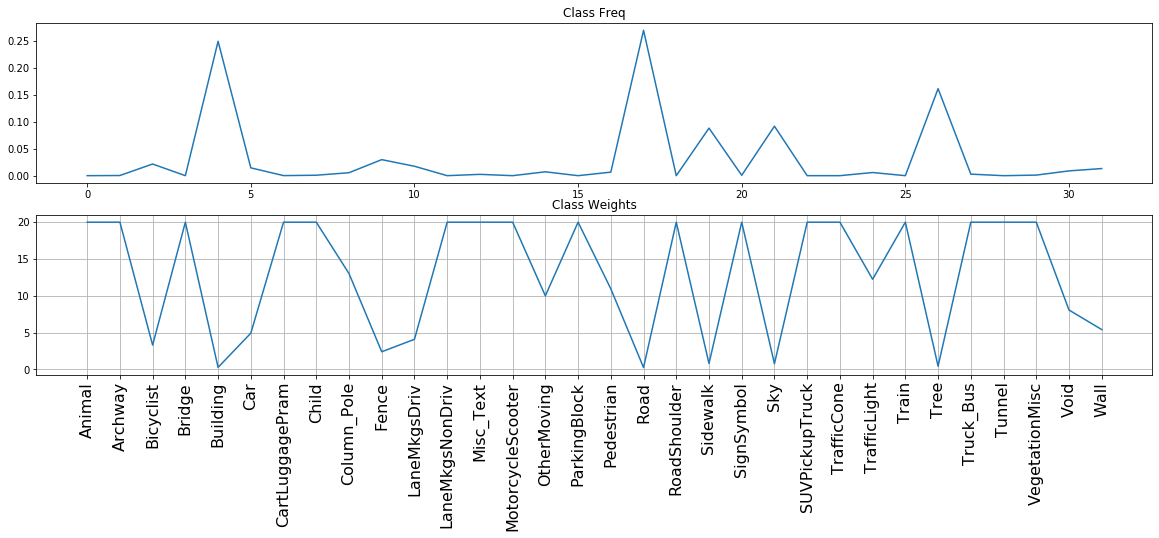

In [21]:
total_pixels = np.sum(n)
class_freq = n / total_pixels

# class_freq = np.copy(class_freq)

print(class_freq, np.median(class_freq))
# print("\nSorted Class Freq:",np.sort(class_freq))
# print("Median: {}".format(np.median(class_freq)))

# Remove values that are 0
class_freq_nonzero = class_freq[class_freq !=0]

# print("Nonzero Class Freq:",np.sort(class_freq_nonzero))
print("Median: {}".format(np.median(class_freq_nonzero)))

# class_freq[class_freq<1e-10] = 0.1
# print("Class Frequency: {}".format(class_freq))

class_weights = 10*np.median(class_freq_nonzero) / (class_freq + 1e-10)
class_weights[class_weights>20]=  20

plt.figure(figsize=(20,10))
# plt.subplots(nrows=1,ncols=3)
plt.subplot(311)
plt.plot(class_freq)
plt.title("Class Freq")
plt.subplot(312)
plt.plot(class_weights)
plt.title("Class Weights")
plt.grid()

xtick_labels = dict_idx_class.values()
#     print(xtick_labels)

# # now, define the ticks (i.e. locations where the labels will be plotted)
xticks = [i for i in range(n_classes)]

# # also define the labels we'll use (note this MUST have the same size as `xticks`!)
# xtick_labels = ['Family-%d' % (f+1) for f in range(NUM_FAMILIES)]

ax = plt.gca()
# add the ticks and labels to the plot
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels,fontsize=16, rotation=90)

print("done")

print(class_weights.shape)
# # print("np.median(class_freq): {}".format(np.median(class_freq)))
# class_weights = np.median(class_freq) / (class_freq + 1e-10)

# class_weights[class_weights>20] = 0.5
# # print("Class Weights: {}".format(class_weights))


# plot_class_histogram(all_idx, dict_idx_class, n_classes)



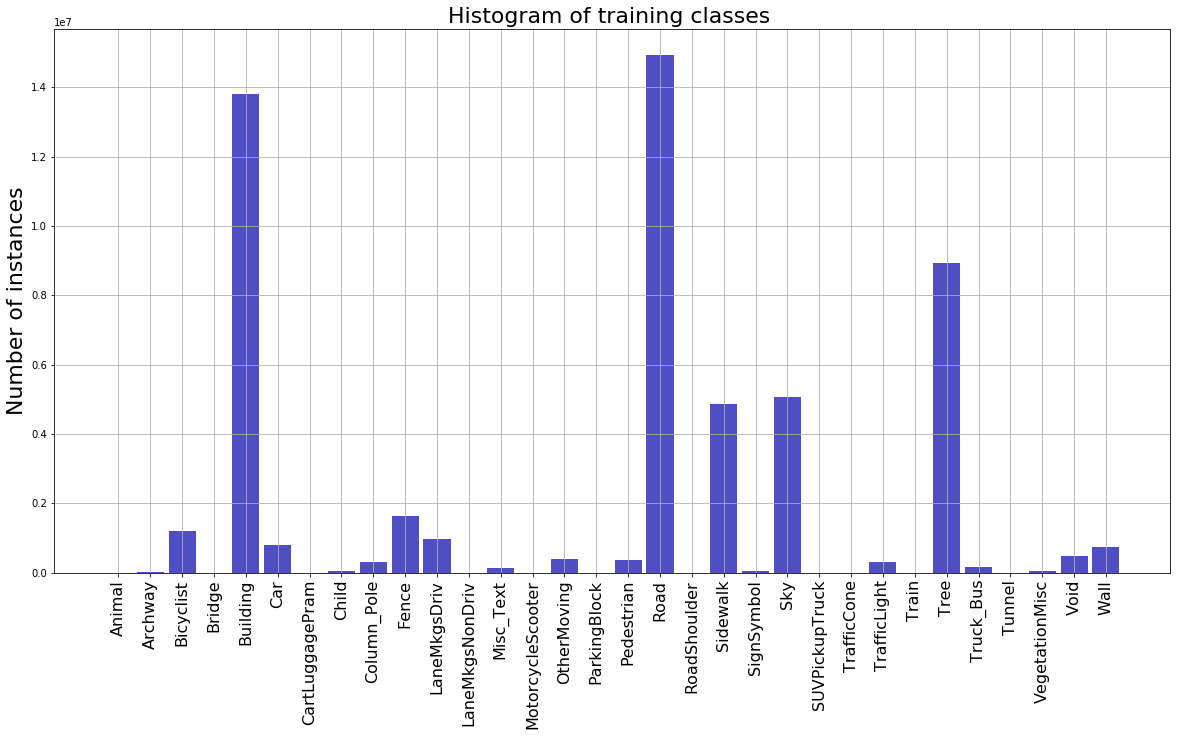

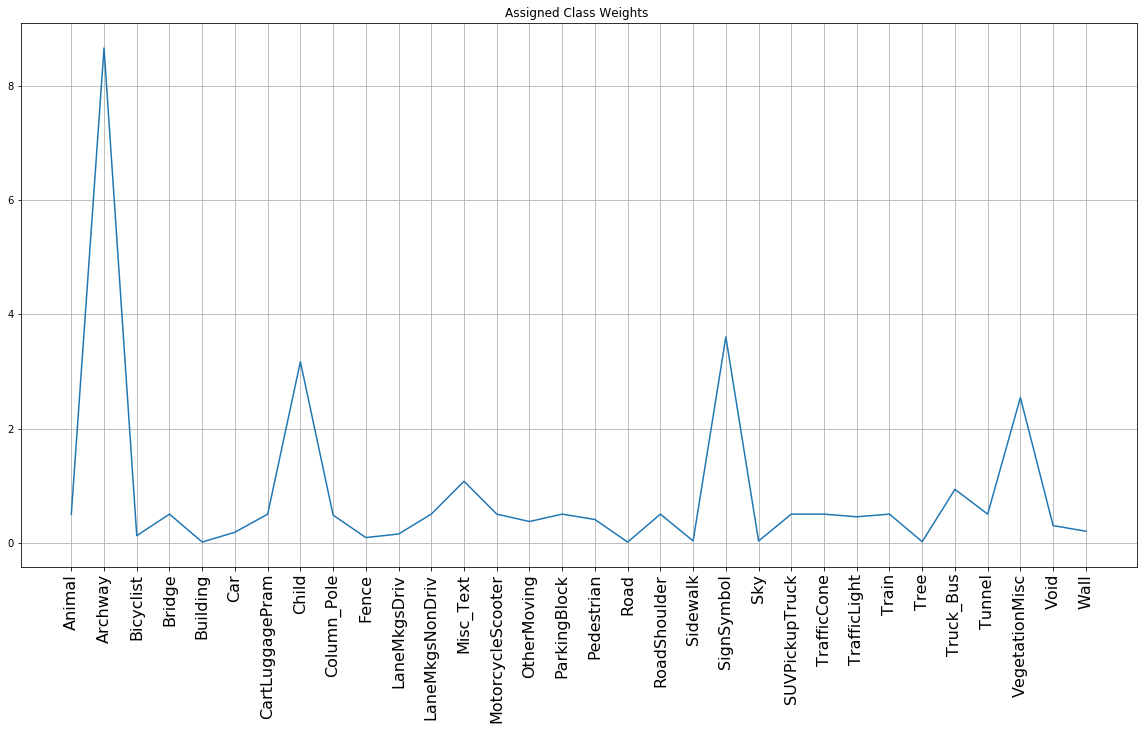

In [22]:

total_pixels = np.sum(n)
class_freq = n / total_pixels

# class_freq = np.copy(class_freq)
# print(class_freq, type(class_freq))

# class_freq[class_freq<1e-10] = 0.1
# print("Class Frequency: {}".format(class_freq))


# plt.figure()
# plt.subplots(nrows=1,ncols=3)
# plt.subplot(311)
# plt.plot(class_freq)
# plt.subplot(312)
# # plt.plot(class_freq2)

# print("np.median(class_freq): {}".format(np.median(class_freq)))
class_weights = np.median(class_freq) / (class_freq + 1e-10)

class_weights[class_weights>20] = 0.5

# TRIAL ONLY: Set all class weights to be 1 for testin
# class_weights[class_weights<1e10] =1

# print("Class Weights: {}".format(class_weights))


plot_class_histogram(all_idx, dict_idx_class, n_classes)

# Plot the weights 
# class_weights[class_weights>50] = np.median(class_weights)/4
# print(class_weights)
plt.figure(figsize=(20,10))
plt.plot(class_weights)
plt.grid()
plt.title('Assigned Class Weights ')

# # # now, define the ticks (i.e. locations where the labels will be plotted)
# xticks = [i for i in range(n_classes)]
xtick_labels = dict_idx_class.values()

# # now, define the ticks (i.e. locations where the labels will be plotted)
xticks = [i for i in range(n_classes)]

# # also define the labels we'll use (note this MUST have the same size as `xticks`!)
# xtick_labels = ['Family-%d' % (f+1) for f in range(NUM_FAMILIES)]

ax = plt.gca()
# add the ticks and labels to the plot
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels,fontsize=16, rotation=90)


# Create a dict for model.fit usage
dict_class_weights = {k:v for k,v in enumerate(class_weights)}

#Create the tensor of weights
tf_class_weights = tf.compat.v2.constant([class_weights.astype('float32')])

# print("Class distribution and class weights ")
# print(dict_class_weights)
# print(np.median(class_weights))


## U Net architecture 

Text(0.5, 1.0, 'U-Net architecture')

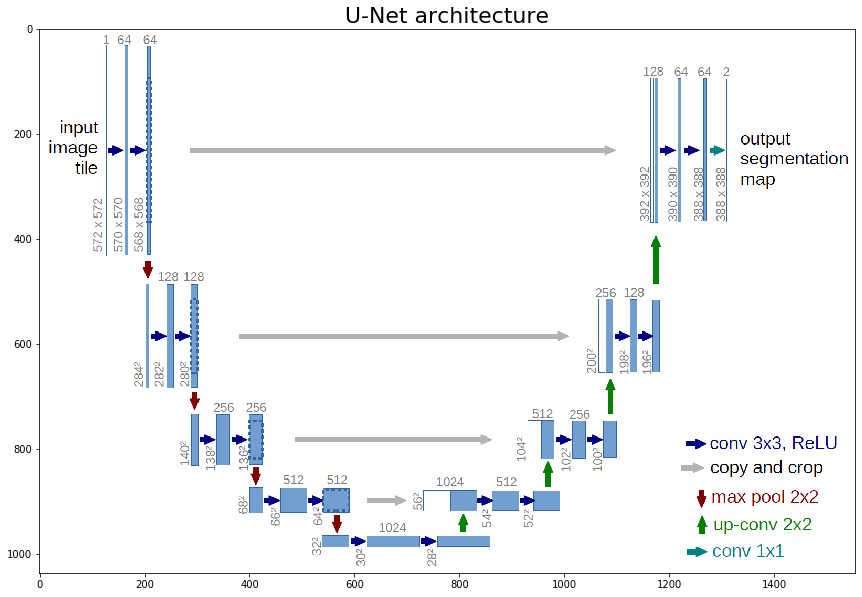

In [23]:
#Show the structure
img = plt.imread("../images/u-net-architecture.png")

plt.figure(figsize=(20,10))
plt.imshow(img)
plt.title("U-Net architecture", fontsize=22)

In [24]:
# Build the model using the functional API
def build_UNET(input_height = IMG_HEIGHT,input_width=IMG_WIDTH, input_channels= INPUT_CHANNELS, 
               n_classes = n_classes, 
               flag_use_bn=True,
               flag_use_dropout = False,
               DROPOUT_FRACTION= 0.2,
               flag_use_weighted_loss_fcn = False):

    #Encoder part
    #Block 1
    input_ = keras.layers.Input(shape=(input_height,input_width,input_channels))
#     c1 = keras.layers.Conv2D(16,kernel_size=(3,3) , kernel_initializer='he_normal', padding='same')(input_)
    c1 = keras.layers.Conv2D(16,kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(input_)
    
    if(flag_use_bn):
        # Apply BN before the activation
        c1 = keras.layers.BatchNormalization()(c1)
    c1 = keras.layers.Activation("relu")(c1)
        
    c1 = keras.layers.Conv2D(16,(3,3) , kernel_initializer='he_normal',padding='same')(c1)    
    if(flag_use_bn):
        # Apply BN before the activation
        c1 = keras.layers.BatchNormalization()(c1)
    c1 = keras.layers.Activation("relu")(c1)

    #Block 2
    p1 = keras.layers.MaxPool2D((2,2))(c1)
    if(flag_use_dropout):
        p1 = keras.layers.Dropout(DROPOUT_FRACTION)(p1)
    c2 = keras.layers.Conv2D(32,(3,3) , kernel_initializer='he_normal',padding='same')(p1)
    if(flag_use_bn):
        # Apply BN before the activation
        c2 = keras.layers.BatchNormalization()(c2)
    c2 = keras.layers.Activation("relu")(c2)

    c2 = keras.layers.Conv2D(32,(3,3) , kernel_initializer='he_normal',padding='same')(c2)
    if(flag_use_bn):
        # Apply BN before the activation
        c2 = keras.layers.BatchNormalization()(c2)
    c2 = keras.layers.Activation("relu")(c2)

    #Block 3
    p2 = keras.layers.MaxPool2D((2,2))(c2)
    if(flag_use_dropout):
        p2 = keras.layers.Dropout(DROPOUT_FRACTION)(p2)
    c3 = keras.layers.Conv2D(64,(3,3) , kernel_initializer='he_normal',padding='same')(p2)
    if(flag_use_bn):
        # Apply BN before the activation
        c3 = keras.layers.BatchNormalization()(c3)
    c3 = keras.layers.Activation("relu")(c3)

    c3 = keras.layers.Conv2D(64,(3,3) , kernel_initializer='he_normal',padding='same')(c3)
    if(flag_use_bn):
        # Apply BN before the activation
        c3 = keras.layers.BatchNormalization()(c3)
    c3 = keras.layers.Activation("relu")(c3)

    #Block 4
    p3 = keras.layers.MaxPool2D((2,2))(c3)
    if(flag_use_dropout):
        p3 = keras.layers.Dropout(DROPOUT_FRACTION)(p3)
        
    c4 = keras.layers.Conv2D(128,(3,3) , kernel_initializer='he_normal',padding='same')(p3)
    if(flag_use_bn):
        # Apply BN before the activation
        c4 = keras.layers.BatchNormalization()(c4)
    c4 = keras.layers.Activation("relu")(c4)

    c4 = keras.layers.Conv2D(128,(3,3) , kernel_initializer='he_normal',padding='same')(c4)
    if(flag_use_bn):
        # Apply BN before the activation
        c4 = keras.layers.BatchNormalization()(c4)
    c4 = keras.layers.Activation("relu")(c4)

    #Block 5
    p4 = keras.layers.MaxPool2D((2,2))(c4)
    if(flag_use_dropout):
        p4 = keras.layers.Dropout(DROPOUT_FRACTION)(p4)
    c5 = keras.layers.Conv2D(256,(3,3) , kernel_initializer='he_normal',padding='same')(p4)
    if(flag_use_bn):
        # Apply BN before the activation
        c5 = keras.layers.BatchNormalization()(c5)
    c5 = keras.layers.Activation("relu")(c5)

    c5 = keras.layers.Conv2D(256,(3,3) , kernel_initializer='he_normal',padding='same')(c5)
    if(flag_use_bn):
        # Apply BN before the activation
        c5 = keras.layers.BatchNormalization()(c5)
    c5 = keras.layers.Activation("relu")(c5)


    #Decoder part

    #Block 6
    u1 = keras.layers.Conv2DTranspose(128,(2,2), strides=(2,2) ,padding='same')(c5)
    u1 = keras.layers.concatenate([c4, u1])
    c6 = keras.layers.Conv2D(128,(3,3) , kernel_initializer='he_normal',padding='same')(u1)
    if(flag_use_bn):
        # Apply BN before the activation
        c6 = keras.layers.BatchNormalization()(c6)
    c6 = keras.layers.Activation("relu")(c6)


    c6 = keras.layers.Conv2D(128,(3,3) , kernel_initializer='he_normal',padding='same')(c6)
    if(flag_use_bn):
        # Apply BN before the activation
        c6 = keras.layers.BatchNormalization()(c6)
    c6 = keras.layers.Activation("relu")(c6)

    #Block 7
    u2 = keras.layers.Conv2DTranspose(64,(2,2), strides=(2,2), activation='relu',padding='same')(c6)
    u2 = keras.layers.concatenate([c3,u2])
    c7 = keras.layers.Conv2D(64,(3,3) , kernel_initializer='he_normal',padding='same')(u2)
    if(flag_use_bn):
        # Apply BN before the activation
        c7 = keras.layers.BatchNormalization()(c7)
    c7 = keras.layers.Activation("relu")(c7)

    c7 = keras.layers.Conv2D(64,(3,3) , kernel_initializer='he_normal',padding='same')(c7)
    if(flag_use_bn):
        # Apply BN before the activation
        c7 = keras.layers.BatchNormalization()(c7)
    c7 = keras.layers.Activation("relu")(c7)

    #Block 8
    u3 = keras.layers.Conv2DTranspose(32,(3,3), strides=(2,2), activation='relu',padding='same')(c7)
    u3 = keras.layers.concatenate([c2,u3])
    c8 = keras.layers.Conv2D(32,(3,3) , kernel_initializer='he_normal',padding='same')(u3)
    if(flag_use_bn):
        # Apply BN before the activation
        c8 = keras.layers.BatchNormalization()(c8)
    c8 = keras.layers.Activation("relu")(c8)

    c8 = keras.layers.Conv2D(32,(3,3) , kernel_initializer='he_normal',padding='same')(c8)
    if(flag_use_bn):
        # Apply BN before the activation
        c8 = keras.layers.BatchNormalization()(c8)
    c8 = keras.layers.Activation("relu")(c8)

    #Block 9
    u4 = keras.layers.Conv2DTranspose(16,(2,2), strides=(2,2), activation='relu',padding='same')(c8)
    u4 = keras.layers.concatenate([c1,u4])
    c9 = keras.layers.Conv2D(16,(3,3) , kernel_initializer='he_normal',padding='same')(u4)
    if(flag_use_bn):
        # Apply BN before the activation
        c9 = keras.layers.BatchNormalization()(c9)
    c9 = keras.layers.Activation("relu")(c9)

    c9 = keras.layers.Conv2D(16,(3,3) , kernel_initializer='he_normal',padding='same')(c9)
    if(flag_use_bn):
        # Apply BN before the activation
        c9 = keras.layers.BatchNormalization()(c9)
    c9 = keras.layers.Activation("relu")(c9)

    #Final layer
    # Softmax is using categorical cross entropy. Logits if using the custom loss function
    if(flag_use_weighted_loss_fcn):
        c10 = keras.layers.Conv2D(n_classes,(3,3),activation=None,padding='same',name='final_layer_for_custom_loss')(c9)
    else:
        c10 = keras.layers.Conv2D(n_classes,(3,3),activation='softmax',padding='same',name='final_layer_for_categ_xtropy')(c9)

    outputs = c10

    model = keras.Model(inputs=[input_],outputs=[outputs], name='U-Net')
    
    
    return model


In [25]:
model = build_UNET(input_height = IMG_HEIGHT,input_width=IMG_WIDTH, input_channels= INPUT_CHANNELS, 
               n_classes = n_classes, 
               flag_use_bn=False,
               flag_use_dropout = True,
               DROPOUT_FRACTION= 0.2,
               flag_use_weighted_loss_fcn =flag_use_weighted_loss_fcn)

model.summary()



Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        activation[0][0]                 
______________________________________________________________________________________________

__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 64, 64, 64)   36928       activation_12[0][0]              
__________________________________________________________________________________________________
activation_13 (Activation)      (None, 64, 64, 64)   0           conv2d_13[0][0]                  
__________________________________________________________________________________________________
conv2d_transpose_2 (Conv2DTrans (None, 128, 128, 32) 18464       activation_13[0][0]              
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 128, 128, 64) 0           activation_3[0][0]               
                                                                 conv2d_transpose_2[0][0]         
__________________________________________________________________________________________________
conv2d_14 

In [26]:
# Plot the model
try:
    tf.keras.utils.plot_model(model,show_shapes=True)
except Exception as ex:
    print(ex)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [27]:
model_folder_name = "unet_camvid"
model_name = model_folder_name + ".h5"


#ModelCheckpoint - Save only the best model
save_model_filepath = os.path.join(os.path.abspath(os.pardir),"models",model_folder_name,model_name)

print("ModelCheckpoint Callback saves the model in: {}".format(save_model_filepath))

checkpoint_cb = keras.callbacks.ModelCheckpoint(save_model_filepath,
                                               save_best_only=True)

# Early stopping.
# ModelCheckpoint will save best, but wont stop training, which might go on for a long time and consume resources.
# Early stoppoing callback helps with this
# early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                      patience=10,
#                                                      restore_best_weights=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20,
                                                  restore_best_weights=True)

#Create a custom callback if needed. For example, display the ratio of validation loss / training_loss to detect overfitting
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs):
        print("\n Custom Callback - Epoch: {}, val/train loss ratio: {:.2f}".format(epoch, logs["val_loss"] / logs["loss"]))

#Instance of the custom callback
print_ratio_cb = PrintValTrainRatioCallback()

#Tensorboard callback

#Note:
#For windows, forward and back slahses are painful to get right for the tensorboard usage.
# What works is that create a windows path, and replace the \ with \\

#Save data in models folder.
root_logdir = os.path.join(os.pardir, "models", model_folder_name, "tensorboard", "my_logs")
print("Tensorboard parent logs folder: {}".format(root_logdir))

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d_%H_%M_%S")
    return os.path.join(root_logdir,run_id)

run_logdir = get_run_logdir()
print("Current logdir: {}".format(run_logdir))

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)



def show_onehot_predictions(im_array,mask_array):
    pred_intermediate = model.predict(im_array)
    for i in range(pred_intermediate.shape[0]):
        fig = plt.figure(figsize=(20,8))

        ax1 = fig.add_subplot(1,3,1)
        ax1.imshow(im_array[i])
        ax1.title.set_text('Actual frame')
        ax1.grid(b=None)


        ax2 = fig.add_subplot(1,3,2)
        ax2.set_title('Ground truth labels')
        ax2.imshow(onehot_to_rgb(mask_array[i],dict_idx_rgb))
        ax2.grid(b=None)

        ax3 = fig.add_subplot(1,3,3)
        ax3.set_title('Predicted labels')

        ax3.imshow(onehot_to_rgb(pred_intermediate[i],dict_idx_rgb))
        ax3.grid(b=None)

        plt.show()

    
    
    
# Show Segmentation result during the training
class display_prediction_callback(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs):
        # Get some images:
        im_array, mask_array = next(TrainingDataGenerator(batch_size=1))
        show_onehot_predictions(im_array, mask_array)

        
# callbacks=[checkpoint_cb,early_stopping_cb, tensorboard_cb]#, display_prediction_callback()]
callbacks=[checkpoint_cb, tensorboard_cb]#, display_prediction_callback()]


ModelCheckpoint Callback saves the model in: C:\Users\abhat\research\Tensorflow_2.0_tutorials\models\unet_camvid\unet_camvid.h5
Tensorboard parent logs folder: ..\models\unet_camvid\tensorboard\my_logs
Current logdir: ..\models\unet_camvid\tensorboard\my_logs\run_2020_03_17_20_56_25


## Dice Loss 

In [28]:
# Ref: salehi17, "Twersky loss function for image segmentation using 3D FCDN"
# -> the score is computed for each class separately and then summed
# alpha=beta=0.5 : dice coefficient
# alpha=beta=1   : tanimoto coefficient (also known as jaccard)
# alpha+beta=1   : produces set of F*-scores
# implemented by E. Moebel, 06/04/18
def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2,3))
    den = num + alpha*K.sum(p0*g1,(0,1,2,3)) + beta*K.sum(p1*g0,(0,1,2,3))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T

In [29]:
# Create Dice loss
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)

smooth =1.0

### Define custom loss for the weighted softmax 

In [30]:
def weighted_softmax_cross_entropy_with_logits(one_hot_labels,y_pred_logits):
    '''
    reference: https://stackoverflow.com/questions/44560549/unbalanced-data-and-weighted-cross-entropy
    '''
    
#     print("one_hot_labels.shape",one_hot_labels.shape)
#     print("y_pred_logits.shape",y_pred_logits.shape)
    
    # Create a custom loss with weights 
    # your class weights
    # Already defined when defining the weight
#     tf_class_weights = tf.compat.v2.constant([class_weights.astype('float32')])

#     print("tf_class_weights: ", tf_class_weights)
    # deduce weights for batch samples based on their true label
    weights = tf.compat.v2.reduce_sum(tf_class_weights *one_hot_labels, axis=-1)
#     print("weights.shape: {}".format(weights.shape))
#     print("weights.dtype: {}".format(weights.dtype))

    # compute your (unweighted) softmax cross entropy loss
    unweighted_losses = tf.compat.v2.nn.softmax_cross_entropy_with_logits(one_hot_labels, y_pred_logits)
    # print(unweighted_losses)

#     print(unweighted_losses.dtype, weights.dtype)
    # apply the weights, relying on broadcasting of the multiplication
    weighted_losses = unweighted_losses * weights
#     print(weighted_losses[0][0])
#     plt.figure()
#     plt.plot(weighted_losses[0][0])
#     print("weighted_losses.shape:",weighted_losses.shape)
    
    # reduce the result to get your final loss
    loss = tf.reduce_mean(weighted_losses)
    
    return loss


# im_array = test_batch[0]
# onehot_array = test_batch[1]

m_batch = TrainingDataGenerator()
test_batch = next(m_batch)
im_array = test_batch[0]
onehot_array = test_batch[1]

y_pred_logits = model.predict(im_array)

loss = weighted_softmax_cross_entropy_with_logits(onehot_array,y_pred_logits)
print(loss)

In TrainingDataGenerator 
Initializing  TrainingDataGenerator 
Found 80 images belonging to 1 classes.
Found 80 images belonging to 1 classes.
tf.Tensor(0.18917689, shape=(), dtype=float32)


In [31]:
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
if flag_use_weighted_loss_fcn:
    
    model.compile(optimizer=optimizer,
                  loss=weighted_softmax_cross_entropy_with_logits,
                  metrics=[dice_coef,'accuracy'])

else:
    model.compile(optimizer=optimizer,
                  loss="categorical_crossentropy",
                  metrics=[dice_coef,'accuracy'])

In [32]:
batch_size = 8
steps_per_epoch = int(np.floor(num_training_samples / batch_size))
steps_per_epoch

10

In [33]:
validation_steps = int(np.floor(num_validation_samples /batch_size))
validation_steps

2

In [34]:
num_epochs = 200

In [35]:
if flag_train_model:
    
#     batch_size = 5
    result = model.fit_generator(TrainingDataGenerator(batch_size=batch_size),
                                 steps_per_epoch=steps_per_epoch ,
                                 validation_data = ValidationDataGenerator(batch_size=3), 
                                 validation_steps = validation_steps,
                                 epochs=num_epochs,
                                 callbacks=callbacks)

else:
    model = keras.models.load_model('../models/unet_camvid/unet_camvid.h5',
                                   custom_objects={"dice_coef": dice_coef})
    
# model.save_weights("camvid_model_150_epochs.h5", overwrite=True)

W0317 20:56:28.945960 24896 deprecation.py:323] From <ipython-input-35-52d354c36806>:9: Model.fit_generator (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
Please use Model.fit, which supports generators.


In TrainingDataGenerator 
Initializing  TrainingDataGenerator 
Found 80 images belonging to 1 classes.
Found 80 images belonging to 1 classes.


W0317 20:56:30.324111 24896 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


In ValidationDataGenerator 
Initializing  ValidationDataGenerator 
Found 21 images belonging to 1 classes.
Found 21 images belonging to 1 classes.


W0317 20:56:30.871020 24896 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


Train for 10 steps, validate for 2 steps
Epoch 1/200
10/10 [==============================] - ETA: 27s - loss: 3.4294 - dice_coef: 0.0620 - accuracy: 0.038 - ETA: 12s - loss: 3.4029 - dice_coef: 0.0625 - accuracy: 0.046 - ETA: 9s - loss: 3.3749 - dice_coef: 0.0626 - accuracy: 0.050 - ETA: 7s - loss: 3.3600 - dice_coef: 0.0628 - accuracy: 0.05 - ETA: 6s - loss: 3.3623 - dice_coef: 0.0632 - accuracy: 0.06 - ETA: 4s - loss: 3.3524 - dice_coef: 0.0635 - accuracy: 0.06 - ETA: 3s - loss: 3.3502 - dice_coef: 0.0639 - accuracy: 0.07 - ETA: 2s - loss: 3.3502 - dice_coef: 0.0643 - accuracy: 0.07 - ETA: 1s - loss: 3.3451 - dice_coef: 0.0646 - accuracy: 0.08 - 12s 1s/step - loss: 3.3399 - dice_coef: 0.0651 - accuracy: 0.0870 - val_loss: 3.3967 - val_dice_coef: 0.0690 - val_accuracy: 0.1378
Epoch 2/200
10/10 [==============================] - ETA: 2s - loss: 3.2628 - dice_coef: 0.0714 - accuracy: 0.13 - ETA: 5s - loss: 3.2846 - dice_coef: 0.0710 - accuracy: 0.12 - ETA: 5s - loss: 3.2863 - dice_coef

Epoch 12/200
10/10 [==============================] - ETA: 2s - loss: 2.2240 - dice_coef: 0.3197 - accuracy: 0.20 - ETA: 5s - loss: 2.1976 - dice_coef: 0.3162 - accuracy: 0.21 - ETA: 5s - loss: 2.2151 - dice_coef: 0.3131 - accuracy: 0.21 - ETA: 5s - loss: 2.2025 - dice_coef: 0.3151 - accuracy: 0.22 - ETA: 4s - loss: 2.1857 - dice_coef: 0.3179 - accuracy: 0.22 - ETA: 4s - loss: 2.1792 - dice_coef: 0.3221 - accuracy: 0.22 - ETA: 3s - loss: 2.1739 - dice_coef: 0.3226 - accuracy: 0.22 - ETA: 2s - loss: 2.1739 - dice_coef: 0.3225 - accuracy: 0.23 - ETA: 1s - loss: 2.1677 - dice_coef: 0.3234 - accuracy: 0.23 - 11s 1s/step - loss: 2.1588 - dice_coef: 0.3257 - accuracy: 0.2386 - val_loss: 2.3059 - val_dice_coef: 0.2954 - val_accuracy: 0.3185
Epoch 13/200
10/10 [==============================] - ETA: 3s - loss: 2.1060 - dice_coef: 0.3591 - accuracy: 0.25 - ETA: 6s - loss: 2.1009 - dice_coef: 0.3566 - accuracy: 0.25 - ETA: 6s - loss: 2.1016 - dice_coef: 0.3499 - accuracy: 0.26 - ETA: 5s - loss: 

Epoch 23/200
10/10 [==============================] - ETA: 3s - loss: 1.0645 - dice_coef: 0.6903 - accuracy: 0.63 - ETA: 5s - loss: 1.0751 - dice_coef: 0.6939 - accuracy: 0.64 - ETA: 5s - loss: 1.0652 - dice_coef: 0.6936 - accuracy: 0.65 - ETA: 5s - loss: 1.0660 - dice_coef: 0.6940 - accuracy: 0.65 - ETA: 4s - loss: 1.0764 - dice_coef: 0.6924 - accuracy: 0.64 - ETA: 3s - loss: 1.0733 - dice_coef: 0.6943 - accuracy: 0.64 - ETA: 2s - loss: 1.0769 - dice_coef: 0.6939 - accuracy: 0.64 - ETA: 1s - loss: 1.0747 - dice_coef: 0.6940 - accuracy: 0.64 - ETA: 0s - loss: 1.0751 - dice_coef: 0.6943 - accuracy: 0.64 - 11s 1s/step - loss: 1.0747 - dice_coef: 0.6937 - accuracy: 0.6458 - val_loss: 1.5623 - val_dice_coef: 0.5429 - val_accuracy: 0.5274
Epoch 24/200
10/10 [==============================] - ETA: 4s - loss: 1.0502 - dice_coef: 0.6967 - accuracy: 0.63 - ETA: 6s - loss: 1.0412 - dice_coef: 0.6984 - accuracy: 0.64 - ETA: 6s - loss: 1.0432 - dice_coef: 0.7052 - accuracy: 0.64 - ETA: 5s - loss: 

Epoch 34/200
10/10 [==============================] - ETA: 4s - loss: 0.7278 - dice_coef: 0.8158 - accuracy: 0.76 - ETA: 6s - loss: 0.7508 - dice_coef: 0.8095 - accuracy: 0.75 - ETA: 6s - loss: 0.7549 - dice_coef: 0.8087 - accuracy: 0.75 - ETA: 5s - loss: 0.7586 - dice_coef: 0.8077 - accuracy: 0.75 - ETA: 4s - loss: 0.7738 - dice_coef: 0.8031 - accuracy: 0.74 - ETA: 3s - loss: 0.7804 - dice_coef: 0.8013 - accuracy: 0.74 - ETA: 2s - loss: 0.7886 - dice_coef: 0.7983 - accuracy: 0.74 - ETA: 1s - loss: 0.7944 - dice_coef: 0.7963 - accuracy: 0.74 - ETA: 0s - loss: 0.7910 - dice_coef: 0.7966 - accuracy: 0.74 - 11s 1s/step - loss: 0.7904 - dice_coef: 0.7966 - accuracy: 0.7437 - val_loss: 1.2344 - val_dice_coef: 0.6653 - val_accuracy: 0.6502
Epoch 35/200
10/10 [==============================] - ETA: 3s - loss: 0.7219 - dice_coef: 0.8050 - accuracy: 0.75 - ETA: 5s - loss: 0.7423 - dice_coef: 0.8053 - accuracy: 0.75 - ETA: 6s - loss: 0.7599 - dice_coef: 0.7998 - accuracy: 0.74 - ETA: 5s - loss: 

Epoch 45/200
10/10 [==============================] - ETA: 3s - loss: 0.6872 - dice_coef: 0.8216 - accuracy: 0.76 - ETA: 5s - loss: 0.7108 - dice_coef: 0.8145 - accuracy: 0.75 - ETA: 5s - loss: 0.7157 - dice_coef: 0.8157 - accuracy: 0.76 - ETA: 5s - loss: 0.7120 - dice_coef: 0.8178 - accuracy: 0.76 - ETA: 4s - loss: 0.6957 - dice_coef: 0.8193 - accuracy: 0.76 - ETA: 3s - loss: 0.6904 - dice_coef: 0.8200 - accuracy: 0.76 - ETA: 2s - loss: 0.6946 - dice_coef: 0.8204 - accuracy: 0.76 - ETA: 1s - loss: 0.6956 - dice_coef: 0.8193 - accuracy: 0.76 - ETA: 0s - loss: 0.6973 - dice_coef: 0.8185 - accuracy: 0.76 - 11s 1s/step - loss: 0.7043 - dice_coef: 0.8172 - accuracy: 0.7593 - val_loss: 1.1207 - val_dice_coef: 0.7007 - val_accuracy: 0.6741
Epoch 46/200
10/10 [==============================] - ETA: 5s - loss: 0.7877 - dice_coef: 0.8010 - accuracy: 0.73 - ETA: 6s - loss: 0.7440 - dice_coef: 0.8073 - accuracy: 0.74 - ETA: 6s - loss: 0.7195 - dice_coef: 0.8133 - accuracy: 0.75 - ETA: 5s - loss: 

Epoch 56/200
10/10 [==============================] - ETA: 5s - loss: 0.5707 - dice_coef: 0.8509 - accuracy: 0.79 - ETA: 6s - loss: 0.5881 - dice_coef: 0.8483 - accuracy: 0.78 - ETA: 6s - loss: 0.5994 - dice_coef: 0.8451 - accuracy: 0.78 - ETA: 5s - loss: 0.6094 - dice_coef: 0.8438 - accuracy: 0.78 - ETA: 4s - loss: 0.6188 - dice_coef: 0.8410 - accuracy: 0.78 - ETA: 4s - loss: 0.6157 - dice_coef: 0.8408 - accuracy: 0.78 - ETA: 3s - loss: 0.6131 - dice_coef: 0.8416 - accuracy: 0.78 - ETA: 2s - loss: 0.6132 - dice_coef: 0.8420 - accuracy: 0.78 - ETA: 1s - loss: 0.6155 - dice_coef: 0.8410 - accuracy: 0.78 - 11s 1s/step - loss: 0.6172 - dice_coef: 0.8399 - accuracy: 0.7818 - val_loss: 1.0040 - val_dice_coef: 0.7301 - val_accuracy: 0.6934
Epoch 57/200
10/10 [==============================] - ETA: 4s - loss: 0.5750 - dice_coef: 0.8511 - accuracy: 0.79 - ETA: 5s - loss: 0.6198 - dice_coef: 0.8424 - accuracy: 0.78 - ETA: 5s - loss: 0.6044 - dice_coef: 0.8457 - accuracy: 0.78 - ETA: 5s - loss: 

Epoch 67/200
10/10 [==============================] - ETA: 4s - loss: 0.6173 - dice_coef: 0.8382 - accuracy: 0.77 - ETA: 6s - loss: 0.5862 - dice_coef: 0.8429 - accuracy: 0.77 - ETA: 6s - loss: 0.5959 - dice_coef: 0.8415 - accuracy: 0.78 - ETA: 5s - loss: 0.5866 - dice_coef: 0.8443 - accuracy: 0.78 - ETA: 4s - loss: 0.5729 - dice_coef: 0.8495 - accuracy: 0.79 - ETA: 3s - loss: 0.5852 - dice_coef: 0.8471 - accuracy: 0.78 - ETA: 3s - loss: 0.5794 - dice_coef: 0.8482 - accuracy: 0.78 - ETA: 2s - loss: 0.5775 - dice_coef: 0.8493 - accuracy: 0.79 - ETA: 1s - loss: 0.5743 - dice_coef: 0.8508 - accuracy: 0.79 - 11s 1s/step - loss: 0.5762 - dice_coef: 0.8508 - accuracy: 0.7934 - val_loss: 0.8866 - val_dice_coef: 0.7607 - val_accuracy: 0.7279
Epoch 68/200
10/10 [==============================] - ETA: 5s - loss: 0.5632 - dice_coef: 0.8413 - accuracy: 0.77 - ETA: 6s - loss: 0.5592 - dice_coef: 0.8496 - accuracy: 0.78 - ETA: 6s - loss: 0.5459 - dice_coef: 0.8542 - accuracy: 0.79 - ETA: 5s - loss: 

Epoch 78/200
10/10 [==============================] - ETA: 2s - loss: 0.5324 - dice_coef: 0.8650 - accuracy: 0.82 - ETA: 4s - loss: 0.5197 - dice_coef: 0.8672 - accuracy: 0.82 - ETA: 5s - loss: 0.5305 - dice_coef: 0.8641 - accuracy: 0.81 - ETA: 4s - loss: 0.5217 - dice_coef: 0.8655 - accuracy: 0.81 - ETA: 4s - loss: 0.5184 - dice_coef: 0.8659 - accuracy: 0.81 - ETA: 3s - loss: 0.5174 - dice_coef: 0.8664 - accuracy: 0.81 - ETA: 2s - loss: 0.5300 - dice_coef: 0.8627 - accuracy: 0.81 - ETA: 1s - loss: 0.5304 - dice_coef: 0.8624 - accuracy: 0.81 - ETA: 0s - loss: 0.5303 - dice_coef: 0.8623 - accuracy: 0.81 - 11s 1s/step - loss: 0.5303 - dice_coef: 0.8626 - accuracy: 0.8136 - val_loss: 0.6650 - val_dice_coef: 0.8318 - val_accuracy: 0.8142
Epoch 79/200
10/10 [==============================] - ETA: 2s - loss: 0.4746 - dice_coef: 0.8795 - accuracy: 0.83 - ETA: 5s - loss: 0.5097 - dice_coef: 0.8693 - accuracy: 0.81 - ETA: 5s - loss: 0.4900 - dice_coef: 0.8721 - accuracy: 0.81 - ETA: 5s - loss: 

Epoch 89/200
10/10 [==============================] - ETA: 3s - loss: 0.4306 - dice_coef: 0.8911 - accuracy: 0.85 - ETA: 5s - loss: 0.4607 - dice_coef: 0.8826 - accuracy: 0.84 - ETA: 5s - loss: 0.4615 - dice_coef: 0.8822 - accuracy: 0.84 - ETA: 5s - loss: 0.4613 - dice_coef: 0.8830 - accuracy: 0.84 - ETA: 4s - loss: 0.4619 - dice_coef: 0.8821 - accuracy: 0.84 - ETA: 3s - loss: 0.4663 - dice_coef: 0.8794 - accuracy: 0.83 - ETA: 2s - loss: 0.4702 - dice_coef: 0.8771 - accuracy: 0.83 - ETA: 1s - loss: 0.4663 - dice_coef: 0.8773 - accuracy: 0.83 - ETA: 0s - loss: 0.4694 - dice_coef: 0.8764 - accuracy: 0.83 - 11s 1s/step - loss: 0.4656 - dice_coef: 0.8769 - accuracy: 0.8342 - val_loss: 0.6544 - val_dice_coef: 0.8364 - val_accuracy: 0.8118
Epoch 90/200
10/10 [==============================] - ETA: 4s - loss: 0.4801 - dice_coef: 0.8769 - accuracy: 0.83 - ETA: 5s - loss: 0.4750 - dice_coef: 0.8786 - accuracy: 0.83 - ETA: 5s - loss: 0.4877 - dice_coef: 0.8739 - accuracy: 0.83 - ETA: 5s - loss: 

Epoch 100/200
10/10 [==============================] - ETA: 4s - loss: 0.4737 - dice_coef: 0.8657 - accuracy: 0.81 - ETA: 6s - loss: 0.4260 - dice_coef: 0.8781 - accuracy: 0.83 - ETA: 6s - loss: 0.4213 - dice_coef: 0.8803 - accuracy: 0.83 - ETA: 5s - loss: 0.4193 - dice_coef: 0.8828 - accuracy: 0.83 - ETA: 5s - loss: 0.4179 - dice_coef: 0.8831 - accuracy: 0.83 - ETA: 4s - loss: 0.4151 - dice_coef: 0.8844 - accuracy: 0.84 - ETA: 3s - loss: 0.4167 - dice_coef: 0.8850 - accuracy: 0.84 - ETA: 2s - loss: 0.4164 - dice_coef: 0.8860 - accuracy: 0.84 - ETA: 1s - loss: 0.4225 - dice_coef: 0.8843 - accuracy: 0.84 - 11s 1s/step - loss: 0.4213 - dice_coef: 0.8846 - accuracy: 0.8426 - val_loss: 0.5473 - val_dice_coef: 0.8627 - val_accuracy: 0.8317
Epoch 101/200
10/10 [==============================] - ETA: 4s - loss: 0.3965 - dice_coef: 0.8919 - accuracy: 0.85 - ETA: 6s - loss: 0.4066 - dice_coef: 0.8884 - accuracy: 0.84 - ETA: 5s - loss: 0.4145 - dice_coef: 0.8873 - accuracy: 0.84 - ETA: 5s - loss

Epoch 111/200
10/10 [==============================] - ETA: 3s - loss: 0.3655 - dice_coef: 0.8969 - accuracy: 0.85 - ETA: 5s - loss: 0.3672 - dice_coef: 0.8985 - accuracy: 0.86 - ETA: 6s - loss: 0.3747 - dice_coef: 0.8929 - accuracy: 0.85 - ETA: 5s - loss: 0.3772 - dice_coef: 0.8936 - accuracy: 0.85 - ETA: 4s - loss: 0.3747 - dice_coef: 0.8947 - accuracy: 0.85 - ETA: 3s - loss: 0.3711 - dice_coef: 0.8953 - accuracy: 0.85 - ETA: 2s - loss: 0.3769 - dice_coef: 0.8950 - accuracy: 0.85 - ETA: 1s - loss: 0.3744 - dice_coef: 0.8955 - accuracy: 0.85 - ETA: 0s - loss: 0.3777 - dice_coef: 0.8954 - accuracy: 0.85 - 11s 1s/step - loss: 0.3756 - dice_coef: 0.8958 - accuracy: 0.8564 - val_loss: 0.4990 - val_dice_coef: 0.8735 - val_accuracy: 0.8525
Epoch 112/200
10/10 [==============================] - ETA: 5s - loss: 0.3945 - dice_coef: 0.8805 - accuracy: 0.83 - ETA: 6s - loss: 0.3787 - dice_coef: 0.8885 - accuracy: 0.84 - ETA: 5s - loss: 0.3795 - dice_coef: 0.8919 - accuracy: 0.85 - ETA: 5s - loss

Epoch 122/200
10/10 [==============================] - ETA: 2s - loss: 0.3215 - dice_coef: 0.9110 - accuracy: 0.87 - ETA: 5s - loss: 0.3393 - dice_coef: 0.9028 - accuracy: 0.86 - ETA: 5s - loss: 0.3349 - dice_coef: 0.9072 - accuracy: 0.87 - ETA: 4s - loss: 0.3450 - dice_coef: 0.9041 - accuracy: 0.86 - ETA: 4s - loss: 0.3490 - dice_coef: 0.9032 - accuracy: 0.86 - ETA: 3s - loss: 0.3423 - dice_coef: 0.9043 - accuracy: 0.86 - ETA: 2s - loss: 0.3438 - dice_coef: 0.9037 - accuracy: 0.86 - ETA: 1s - loss: 0.3426 - dice_coef: 0.9039 - accuracy: 0.86 - ETA: 0s - loss: 0.3422 - dice_coef: 0.9043 - accuracy: 0.86 - 10s 1s/step - loss: 0.3450 - dice_coef: 0.9033 - accuracy: 0.8683 - val_loss: 0.4463 - val_dice_coef: 0.8861 - val_accuracy: 0.8632
Epoch 123/200
10/10 [==============================] - ETA: 3s - loss: 0.3625 - dice_coef: 0.8913 - accuracy: 0.84 - ETA: 4s - loss: 0.3546 - dice_coef: 0.9006 - accuracy: 0.86 - ETA: 5s - loss: 0.3482 - dice_coef: 0.8975 - accuracy: 0.85 - ETA: 5s - loss

Epoch 133/200
10/10 [==============================] - ETA: 4s - loss: 0.3021 - dice_coef: 0.9160 - accuracy: 0.88 - ETA: 6s - loss: 0.2962 - dice_coef: 0.9166 - accuracy: 0.88 - ETA: 5s - loss: 0.3102 - dice_coef: 0.9132 - accuracy: 0.88 - ETA: 5s - loss: 0.3081 - dice_coef: 0.9130 - accuracy: 0.88 - ETA: 4s - loss: 0.3160 - dice_coef: 0.9124 - accuracy: 0.88 - ETA: 3s - loss: 0.3116 - dice_coef: 0.9125 - accuracy: 0.88 - ETA: 2s - loss: 0.3099 - dice_coef: 0.9127 - accuracy: 0.88 - ETA: 1s - loss: 0.3132 - dice_coef: 0.9120 - accuracy: 0.87 - ETA: 0s - loss: 0.3170 - dice_coef: 0.9117 - accuracy: 0.87 - 10s 996ms/step - loss: 0.3148 - dice_coef: 0.9121 - accuracy: 0.8801 - val_loss: 0.4239 - val_dice_coef: 0.8912 - val_accuracy: 0.8746
Epoch 134/200
10/10 [==============================] - ETA: 3s - loss: 0.3649 - dice_coef: 0.9003 - accuracy: 0.86 - ETA: 5s - loss: 0.3281 - dice_coef: 0.9077 - accuracy: 0.87 - ETA: 6s - loss: 0.3244 - dice_coef: 0.9077 - accuracy: 0.87 - ETA: 5s - l

Epoch 144/200
10/10 [==============================] - ETA: 2s - loss: 0.2793 - dice_coef: 0.9247 - accuracy: 0.89 - ETA: 5s - loss: 0.3007 - dice_coef: 0.9161 - accuracy: 0.88 - ETA: 5s - loss: 0.2924 - dice_coef: 0.9180 - accuracy: 0.88 - ETA: 4s - loss: 0.2935 - dice_coef: 0.9173 - accuracy: 0.88 - ETA: 4s - loss: 0.2962 - dice_coef: 0.9168 - accuracy: 0.88 - ETA: 3s - loss: 0.2958 - dice_coef: 0.9167 - accuracy: 0.88 - ETA: 2s - loss: 0.2924 - dice_coef: 0.9172 - accuracy: 0.88 - ETA: 1s - loss: 0.2964 - dice_coef: 0.9166 - accuracy: 0.88 - ETA: 0s - loss: 0.2965 - dice_coef: 0.9167 - accuracy: 0.88 - 10s 1s/step - loss: 0.2963 - dice_coef: 0.9169 - accuracy: 0.8864 - val_loss: 0.4065 - val_dice_coef: 0.8962 - val_accuracy: 0.8740
Epoch 145/200
10/10 [==============================] - ETA: 4s - loss: 0.3120 - dice_coef: 0.9084 - accuracy: 0.87 - ETA: 6s - loss: 0.2977 - dice_coef: 0.9124 - accuracy: 0.87 - ETA: 6s - loss: 0.2950 - dice_coef: 0.9116 - accuracy: 0.87 - ETA: 5s - loss

Epoch 155/200
10/10 [==============================] - ETA: 3s - loss: 0.2919 - dice_coef: 0.9197 - accuracy: 0.89 - ETA: 5s - loss: 0.2739 - dice_coef: 0.9235 - accuracy: 0.89 - ETA: 5s - loss: 0.2842 - dice_coef: 0.9217 - accuracy: 0.89 - ETA: 5s - loss: 0.2753 - dice_coef: 0.9223 - accuracy: 0.89 - ETA: 4s - loss: 0.2768 - dice_coef: 0.9223 - accuracy: 0.89 - ETA: 3s - loss: 0.2787 - dice_coef: 0.9196 - accuracy: 0.88 - ETA: 2s - loss: 0.2784 - dice_coef: 0.9196 - accuracy: 0.88 - ETA: 1s - loss: 0.2808 - dice_coef: 0.9184 - accuracy: 0.88 - ETA: 0s - loss: 0.2818 - dice_coef: 0.9177 - accuracy: 0.88 - 11s 1s/step - loss: 0.2816 - dice_coef: 0.9173 - accuracy: 0.8852 - val_loss: 0.4111 - val_dice_coef: 0.8938 - val_accuracy: 0.8771
Epoch 156/200
10/10 [==============================] - ETA: 3s - loss: 0.2658 - dice_coef: 0.9239 - accuracy: 0.89 - ETA: 5s - loss: 0.2836 - dice_coef: 0.9221 - accuracy: 0.89 - ETA: 5s - loss: 0.2831 - dice_coef: 0.9189 - accuracy: 0.88 - ETA: 5s - loss

Epoch 166/200
10/10 [==============================] - ETA: 3s - loss: 0.2644 - dice_coef: 0.9198 - accuracy: 0.88 - ETA: 5s - loss: 0.2639 - dice_coef: 0.9198 - accuracy: 0.88 - ETA: 5s - loss: 0.2696 - dice_coef: 0.9192 - accuracy: 0.88 - ETA: 5s - loss: 0.2698 - dice_coef: 0.9216 - accuracy: 0.89 - ETA: 4s - loss: 0.2703 - dice_coef: 0.9211 - accuracy: 0.89 - ETA: 3s - loss: 0.2679 - dice_coef: 0.9214 - accuracy: 0.89 - ETA: 2s - loss: 0.2737 - dice_coef: 0.9190 - accuracy: 0.88 - ETA: 1s - loss: 0.2699 - dice_coef: 0.9195 - accuracy: 0.88 - ETA: 0s - loss: 0.2692 - dice_coef: 0.9189 - accuracy: 0.88 - 11s 1s/step - loss: 0.2688 - dice_coef: 0.9189 - accuracy: 0.8850 - val_loss: 0.3543 - val_dice_coef: 0.9083 - val_accuracy: 0.8908
Epoch 167/200
10/10 [==============================] - ETA: 4s - loss: 0.2337 - dice_coef: 0.9230 - accuracy: 0.88 - ETA: 6s - loss: 0.2486 - dice_coef: 0.9225 - accuracy: 0.89 - ETA: 6s - loss: 0.2531 - dice_coef: 0.9214 - accuracy: 0.88 - ETA: 5s - loss

Epoch 177/200
10/10 [==============================] - ETA: 3s - loss: 0.2682 - dice_coef: 0.9204 - accuracy: 0.88 - ETA: 6s - loss: 0.2644 - dice_coef: 0.9204 - accuracy: 0.88 - ETA: 6s - loss: 0.2759 - dice_coef: 0.9160 - accuracy: 0.88 - ETA: 5s - loss: 0.2727 - dice_coef: 0.9192 - accuracy: 0.88 - ETA: 4s - loss: 0.2687 - dice_coef: 0.9190 - accuracy: 0.88 - ETA: 3s - loss: 0.2698 - dice_coef: 0.9189 - accuracy: 0.88 - ETA: 2s - loss: 0.2697 - dice_coef: 0.9192 - accuracy: 0.88 - ETA: 2s - loss: 0.2648 - dice_coef: 0.9206 - accuracy: 0.88 - ETA: 1s - loss: 0.2626 - dice_coef: 0.9212 - accuracy: 0.88 - 11s 1s/step - loss: 0.2645 - dice_coef: 0.9209 - accuracy: 0.8888 - val_loss: 0.3172 - val_dice_coef: 0.9192 - val_accuracy: 0.9057
Epoch 178/200
10/10 [==============================] - ETA: 3s - loss: 0.2589 - dice_coef: 0.9199 - accuracy: 0.88 - ETA: 6s - loss: 0.2505 - dice_coef: 0.9212 - accuracy: 0.88 - ETA: 6s - loss: 0.2547 - dice_coef: 0.9211 - accuracy: 0.88 - ETA: 5s - loss

Epoch 188/200
10/10 [==============================] - ETA: 4s - loss: 0.2695 - dice_coef: 0.9236 - accuracy: 0.89 - ETA: 6s - loss: 0.2544 - dice_coef: 0.9198 - accuracy: 0.88 - ETA: 6s - loss: 0.2513 - dice_coef: 0.9217 - accuracy: 0.88 - ETA: 5s - loss: 0.2499 - dice_coef: 0.9219 - accuracy: 0.88 - ETA: 4s - loss: 0.2482 - dice_coef: 0.9235 - accuracy: 0.88 - ETA: 3s - loss: 0.2485 - dice_coef: 0.9237 - accuracy: 0.89 - ETA: 3s - loss: 0.2500 - dice_coef: 0.9232 - accuracy: 0.88 - ETA: 2s - loss: 0.2486 - dice_coef: 0.9233 - accuracy: 0.88 - ETA: 1s - loss: 0.2497 - dice_coef: 0.9221 - accuracy: 0.88 - 11s 1s/step - loss: 0.2502 - dice_coef: 0.9227 - accuracy: 0.8895 - val_loss: 0.3084 - val_dice_coef: 0.9212 - val_accuracy: 0.9071
Epoch 189/200
10/10 [==============================] - ETA: 3s - loss: 0.2488 - dice_coef: 0.9218 - accuracy: 0.88 - ETA: 5s - loss: 0.2343 - dice_coef: 0.9284 - accuracy: 0.89 - ETA: 5s - loss: 0.2407 - dice_coef: 0.9279 - accuracy: 0.89 - ETA: 5s - loss

Epoch 199/200
10/10 [==============================] - ETA: 5s - loss: 0.2645 - dice_coef: 0.9187 - accuracy: 0.88 - ETA: 6s - loss: 0.2447 - dice_coef: 0.9232 - accuracy: 0.88 - ETA: 6s - loss: 0.2432 - dice_coef: 0.9228 - accuracy: 0.88 - ETA: 6s - loss: 0.2452 - dice_coef: 0.9229 - accuracy: 0.88 - ETA: 5s - loss: 0.2446 - dice_coef: 0.9218 - accuracy: 0.88 - ETA: 4s - loss: 0.2433 - dice_coef: 0.9224 - accuracy: 0.88 - ETA: 3s - loss: 0.2416 - dice_coef: 0.9228 - accuracy: 0.88 - ETA: 2s - loss: 0.2424 - dice_coef: 0.9227 - accuracy: 0.88 - ETA: 1s - loss: 0.2414 - dice_coef: 0.9235 - accuracy: 0.88 - 11s 1s/step - loss: 0.2387 - dice_coef: 0.9249 - accuracy: 0.8914 - val_loss: 0.3301 - val_dice_coef: 0.9131 - val_accuracy: 0.8964
Epoch 200/200
10/10 [==============================] - ETA: 4s - loss: 0.2351 - dice_coef: 0.9276 - accuracy: 0.89 - ETA: 6s - loss: 0.2268 - dice_coef: 0.9294 - accuracy: 0.89 - ETA: 6s - loss: 0.2264 - dice_coef: 0.9294 - accuracy: 0.89 - ETA: 5s - loss

In [36]:
# if flag_train_model:
#     print(result.history)


dict_keys(['loss', 'dice_coef', 'accuracy', 'val_loss', 'val_dice_coef', 'val_accuracy'])
(3,)


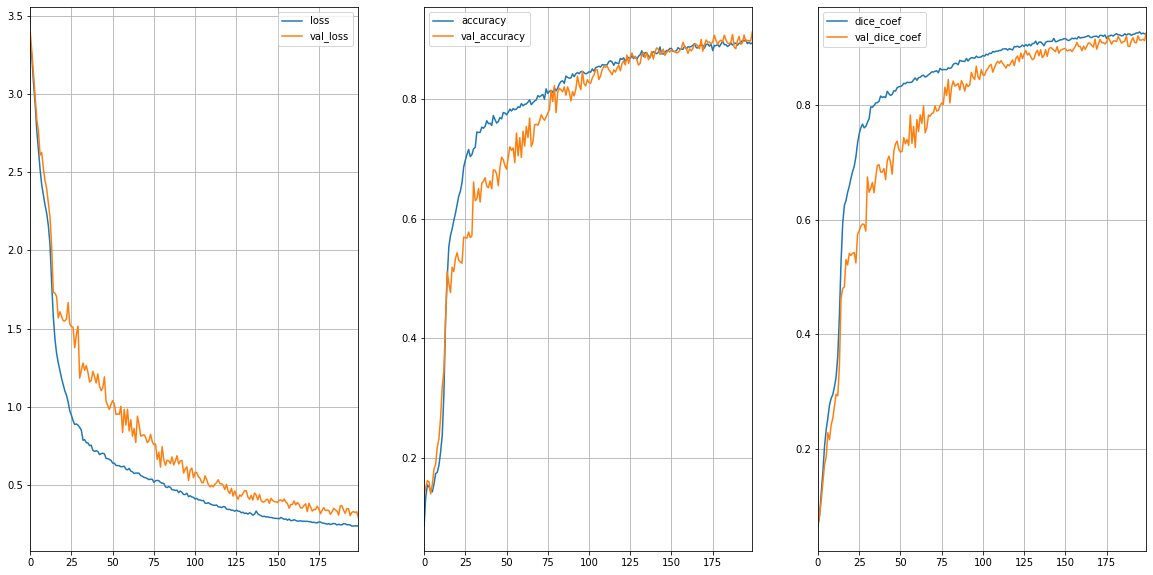

In [37]:
# Plot the history only if training was done

if flag_train_model:
    
    # Plot the history
    import pandas as pd

    print(result.history.keys())
    
    df = pd.DataFrame(result.history)
        
    fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(20,10))
    
    labels_to_plot = [['loss','val_loss'], ['accuracy','val_accuracy'],['dice_coef','val_dice_coef']]
    print(axes.shape)
    
    for idx,mx in enumerate(axes):
        df.plot(y=labels_to_plot[idx],ax = mx)
        
        # Enable grid on all subplots
        mx.grid(True)
            
    # plt.gca().set_ylim(0,10)

In [38]:
testing_gen = ValidationDataGenerator()



In [39]:
batch_img,batch_mask = next(testing_gen)
pred_all= model.predict(batch_img)
np.shape(pred_all)

In ValidationDataGenerator 
Initializing  ValidationDataGenerator 
Found 21 images belonging to 1 classes.
Found 21 images belonging to 1 classes.


(5, 256, 256, 32)

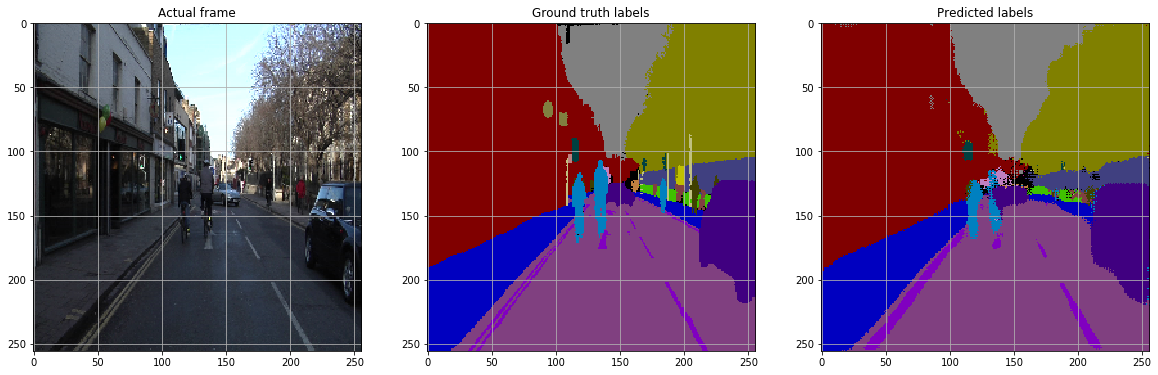

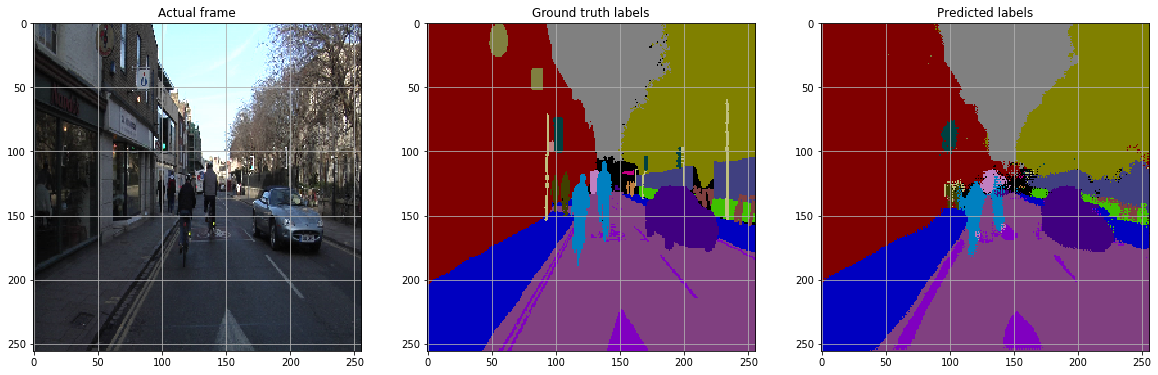

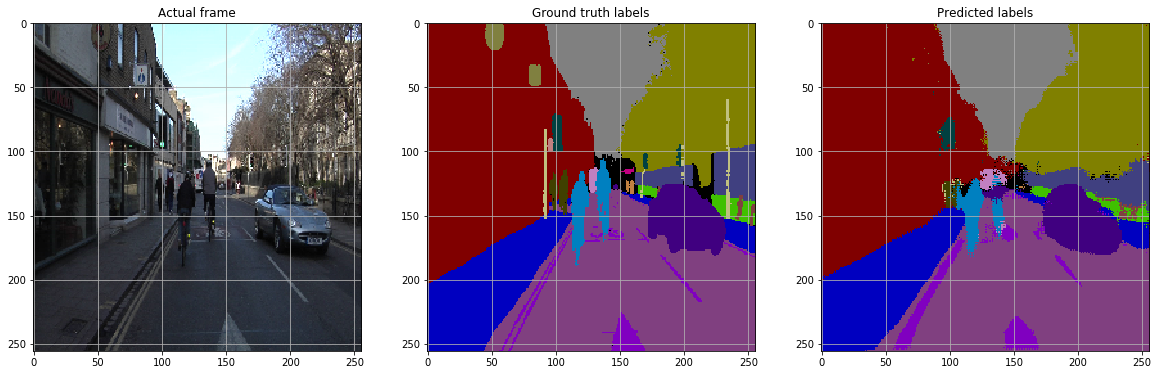

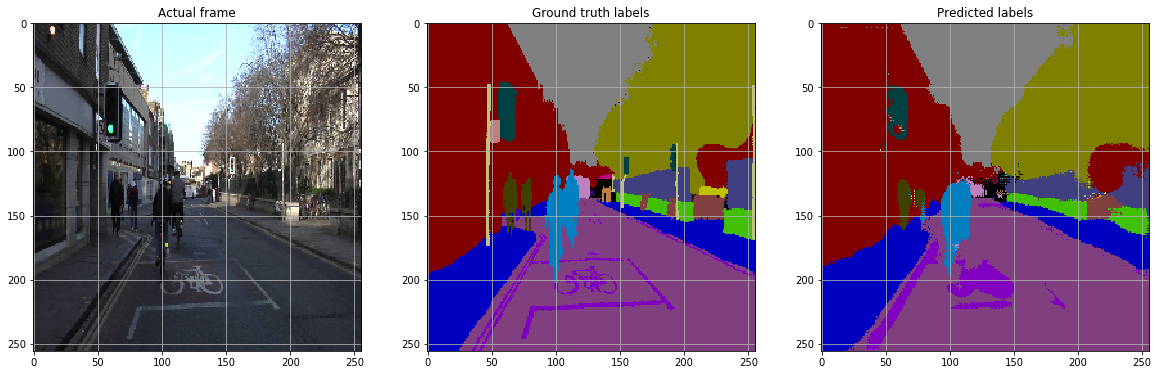

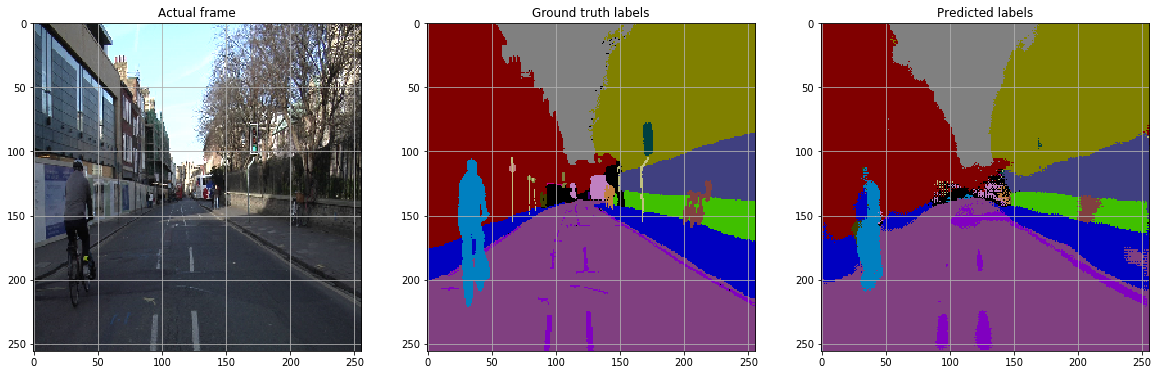

In [40]:
pred_all.shape

show_onehot_predictions(batch_img,batch_mask)


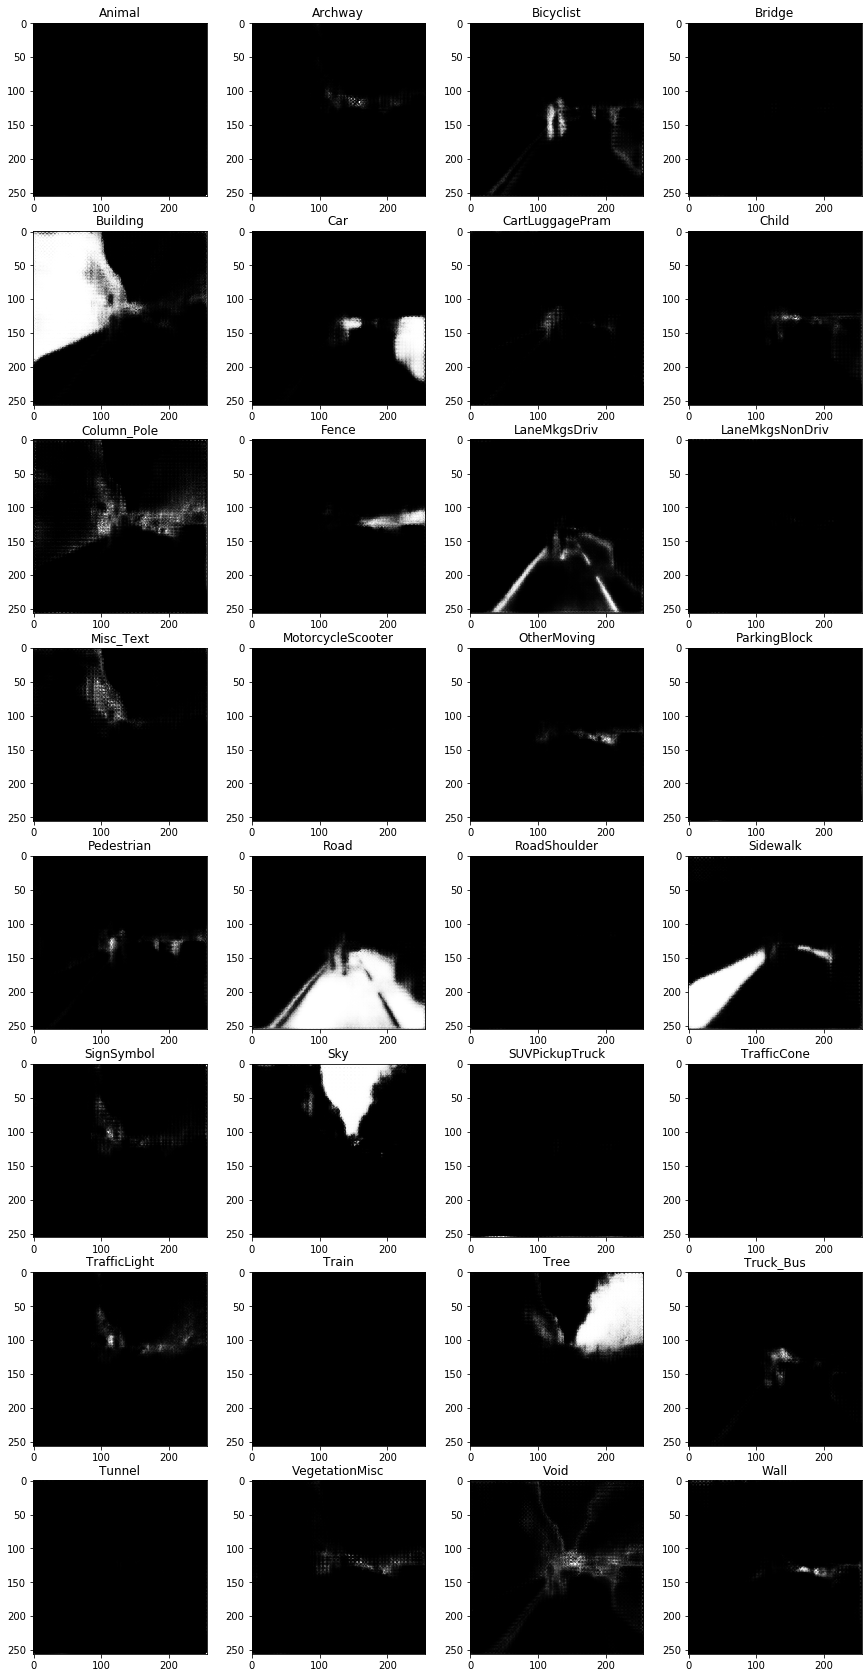

In [41]:
# out = onehot_to_rgb(pred_all[0],dict_idx_rgb)
# out.shape

# Show the individual channels for one of the images. Each channel represents a single class

plt.figure(figsize=(15,30))

for i in range(32):
    plt.subplot(8,4,i+1)
    plt.imshow(pred_all[0,:,:,i], cmap='gray')
    plt.title(dict_idx_class[i])
    
    